## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'/src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Users\dawson\Documents\GitHub\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

C:\Users\dawson\Documents\Google Drive\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Notebook Parameters

In [4]:
import os 

### parameters 

notebook_name = 'exp18_model_topology' # name of the notebook

## Generation of ground truth model 

model_name = 'v4_drug_model' # name of the model
o_random_seed = 5
# p_overall_seed = 46 # different seed for parameter generation
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (1000, 5000)
param_range = (0.8, 1.2)
param_multiplier_range = (0.99, 1.01)


## Simulation parameters 

simulation_time = 1000 
simulation_step = 100

## Feature data generation 

feature_generation_method = 'lhs'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Data engineering parameters

# Suboptimal Model Generation 

'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
- 'random parameter': randomizes a x% of parameter values of the model
'''

''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters
parallelise = True
save_figures = True 
experiment_id = notebook_name + '_' + str(o_random_seed) + '_' + '_' + str(feature_generation_seed)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

C:\Users\dawson\Documents\Google Drive\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp18_model_topology_5__50/


## Analysis

### Virtual Cell Creation

In [5]:
# create a drug enabled model 
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

model_drug_spec = DrugModelSpecification()
model_drug_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
drug_0 = Drug('D0', 500, 500)
rng = np.random.default_rng(o_random_seed)
# add random 'up' and 'down' regulations to the drug
regulation_dir = []
for i, s in enumerate(model_drug_spec.A_species):
    reg_type = str(rng.choice(['up', 'down']))
    regulation_dir.append(reg_type)
    drug_0.add_regulation(s, reg_type)
model_drug_spec.add_drug(drug_0)
print(model_drug_spec)
print(f'Feedback: {model_drug_spec.get_feedback_regulations()}')

A Species: ['A0', 'A1', 'A2', 'A3', 'A4']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4']
C Species: ['C']
Regulations: [('B4', 'B3'), ('B4', 'B0'), ('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4'), ('B0', 'C'), ('B1', 'C'), ('B2', 'C'), ('B3', 'C'), ('B4', 'C'), ('D0', 'A0'), ('D0', 'A1'), ('D0', 'A2'), ('D0', 'A3'), ('D0', 'A4')]
Regulation Types: ['up', 'down', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'down', 'down', 'down', 'down', 'up', 'down', 'up']
Drugs:
Drug(D0, 500, ['A0', 'A1', 'A2', 'A3', 'A4'], ['down', 'down', 'up', 'down', 'up'])

Feedback: [(('B4', 'B3'), 'up'), (('B4', 'B0'), 'down')]


In [6]:
p_random_seeds = []
feature_size = 1000 
rng = np.random.default_rng(o_random_seed)
# generate `feature_size` random seeds for different parameter sets using numpy, ensure that the seeds are unique
p_random_seeds = rng.choice(range(1000000), feature_size, replace=False).tolist()

In [7]:
G0_d = model_drug_spec.generate_network('drug_model_524', 
                                        specie_value_range, 
                                        param_range, 
                                        param_multiplier_range,  
                                        verbose=0,
                                        random_seed=p_random_seeds[0])
base_parameters = G0_d.get_parameters()
base_initial_conditions = G0_d.get_state_variables()

print(G0_d.get_antimony_model())

model drug_model_524

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km*(1+D0*J1_Kic0) + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; J3_Vmax*A1/(J3_Km*(1+D0*J3_Kic0) + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; (J5_Vmax+D0*J5_Kw0)*A2/(J5_Km + A2)
J6: A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)
J7: A3 -> A3p; J7_Vmax*A3/(J7_Km*(1+D0*J7_Kic0) + A3)
J8: A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)
J9: A4 -> A4p; (J9_Vmax+D0*J9_Kw0)*A4/(J9_Km + A4)
J10: B0p -> B0; J10_Vmax*B0p/(J10_Km + B0p)
J11: B0 -> B0p; (J11_Vmax+A0p*J11_Kw0)*B0/(J11_Km*(1+B4p*J11_Kic0) + B0)
J12: B1p -> B1; J12_Vmax*B1p/(J12_Km + B1p)
J13: B1 -> B1p; (J13_Vmax+A1p*J13_Kw0)*B1/(J13_Km + B1)
J14: B2p -> B2; J14_Vmax*B2p/(J14_Km + B2p)
J15: B2 -> B2p; (J15_Vmax+A2p*J15_Kw0)*B2/(J15_Km + B2)
J16: B3p -> B3; J16_Vmax*B3p/(J16_Km + B3p)
J17: B3 -> B3p; (J17_Vmax+B4p*J17_Kw0+A3p*J17_Kw1)*B3/(J17_Km + B3)
J18: B4p -> B4; J18_Vmax*B4p/(J18_Km + B4p)
J19: B4 -> B4p; (J19_Vmax+A4p*J19_Kw

In [8]:
parameter_sets = []
for p in p_random_seeds: 
    model_build = model_drug_spec.generate_network(f'param_seed_{p}', 
                                            specie_value_range, param_range, param_multiplier_range, random_seed=p, verbose=0)
    parameter_sets.append(model_build.get_parameters())

In [9]:
# test simulation 

from models.Solver.RoadrunnerSolver import RoadrunnerSolver

solver = RoadrunnerSolver()
solver.compile(G0_d.get_sbml_model())

original_result = solver.simulate(0, 1000, 100)
original_result

,time,A0p,A0,A1p,A1,A2p,A2,A3p,A3,A4p,...,B4p,B1p,B1,B2p,B2,B3p,B3,B4,C,Cp
0,0.00000,0.000000,3554.000000,0.000000,4841.000000,0.000000,4961.000000,0.000000,1859.000000,0.000000,...,0.000000,0.000000,3277.000000,0.000000,3131.000000,0.000000,1159.000000,2673.000000,100.000000,0.000000
1,10.10101,6.790443,3547.209557,6.849850,4834.150150,6.853854,4954.146146,6.594047,1852.405953,6.822963,...,9.488272,9.575252,3267.424748,9.561084,3121.438916,12.865493,1146.134507,2663.511728,95.142030,4.857970
2,20.20202,9.847902,3544.152098,9.936315,4831.063685,9.942274,4951.057726,9.555620,1849.444380,9.896300,...,16.832916,17.002153,3259.997847,16.977292,3114.022708,27.833494,1131.166506,2656.167084,92.431277,7.568723
3,30.30303,11.284281,3542.715719,11.387859,4829.612141,11.394841,4949.605159,10.941941,1848.058059,11.340979,...,21.950125,22.186427,3254.813573,22.153588,3108.846412,41.934600,1117.065400,2651.049875,91.388802,8.611198
4,40.40404,11.971675,3542.028325,12.083353,4828.916647,12.090880,4948.909120,11.602659,1847.397341,12.032806,...,25.354189,25.641925,3251.358075,25.603241,3105.396759,54.327001,1104.672999,2647.645811,91.170533,8.829467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,959.59596,4.655967,3549.344033,5.618449,4835.381551,4930.703886,30.296114,2.932693,1856.067307,4131.874670,...,2670.013052,20.319909,3256.680091,3128.490288,2.509712,1154.580733,4.419267,2.986948,93.588709,6.411291
96,969.69697,4.655967,3549.344033,5.618449,4835.381551,4930.703887,30.296113,2.932693,1856.067307,4131.874670,...,2670.013052,20.319909,3256.680091,3128.490288,2.509712,1154.580733,4.419267,2.986948,93.588709,6.411291
97,979.79798,4.655967,3549.344033,5.618449,4835.381551,4930.703888,30.296112,2.932693,1856.067307,4131.874670,...,2670.013052,20.319909,3256.680091,3128.490288,2.509712,1154.580733,4.419267,2.986948,93.588709,6.411291
98,989.89899,4.655967,3549.344033,5.618449,4835.381551,4930.703889,30.296111,2.932693,1856.067307,4131.874670,...,2670.013052,20.319909,3256.680091,3128.490288,2.509712,1154.580733,4.419267,2.986948,93.588709,6.411291


### Generate synthetic 'omics-like' data

In [10]:
from models.SyntheticGen import generate_feature_data, generate_target_data, generate_feature_data_v2, generate_target_data_diff_build

feature_data = generate_feature_data_v2(model_drug_spec, base_initial_conditions, feature_generation_method, feature_generation_extra_params, 1000, feature_generation_seed)
target_data, _ = generate_target_data_diff_build(model_drug_spec, solver, 
                                                 feature_data, parameter_sets, 
                                                 {'start': 0, 'end': 1000, 'points': 100}, 
                                                 n_cores=1, verbose=True)


Simulating perturbations: 100%|██████████| 1000/1000 [00:05<00:00, 167.53it/s]


In [11]:
pd.to_pickle(feature_data, config["DATA_PATH"] + "/presentations/feature_data_v1.pkl")
pd.to_pickle(target_data, config["DATA_PATH"] + "/presentations/target_data_v1.pkl")

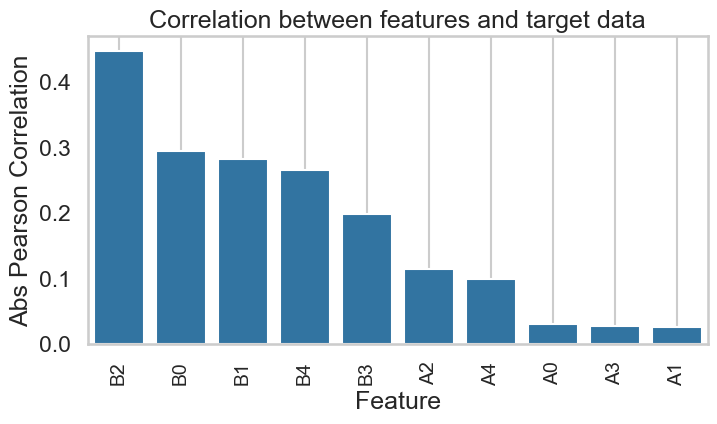

In [12]:
# plot the association between the features and the target data in a bar chart based on the correlation values 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# create a dataframe with the feature data and target data
feature_data_df = pd.DataFrame(feature_data)
target_data_df = pd.DataFrame(target_data)
# add the target data to the feature data
feature_data_df['target'] = target_data_df['Cp']

# calculate the correlation between the features and the target data
correlation = feature_data_df.corr()['target'].sort_values(ascending=False)
# create a dataframe with the correlation values
correlation_df = pd.DataFrame(correlation)
correlation_df = correlation_df.reset_index()
correlation_df.columns = ['feature', 'correlation']
# do not include the target data in the correlation dataframe
correlation_df = correlation_df[correlation_df['feature'] != 'target']
abs_correlation_df = correlation_df.copy()
# take the absolute value of the correlation
abs_correlation_df['correlation'] = abs(abs_correlation_df['correlation'])
# sort the dataframe by the absolute value of the correlation
abs_correlation_df = abs_correlation_df.sort_values(by='correlation', ascending=False)
abs_correlation_df_50 = abs_correlation_df.head(50)

sns.set_context("talk", rc={"font": "Arial"})
sns.set_style('whitegrid')

# plot the correlation values
plt.figure(figsize=(8, 4))
sns.barplot(x='feature', y='correlation', data=abs_correlation_df_50)
plt.title('Correlation between features and target data')
plt.xlabel('Feature')
plt.ylabel('Abs Pearson Correlation')
plt.xticks(rotation=90, fontsize=14)
plt.grid()
plt.show()

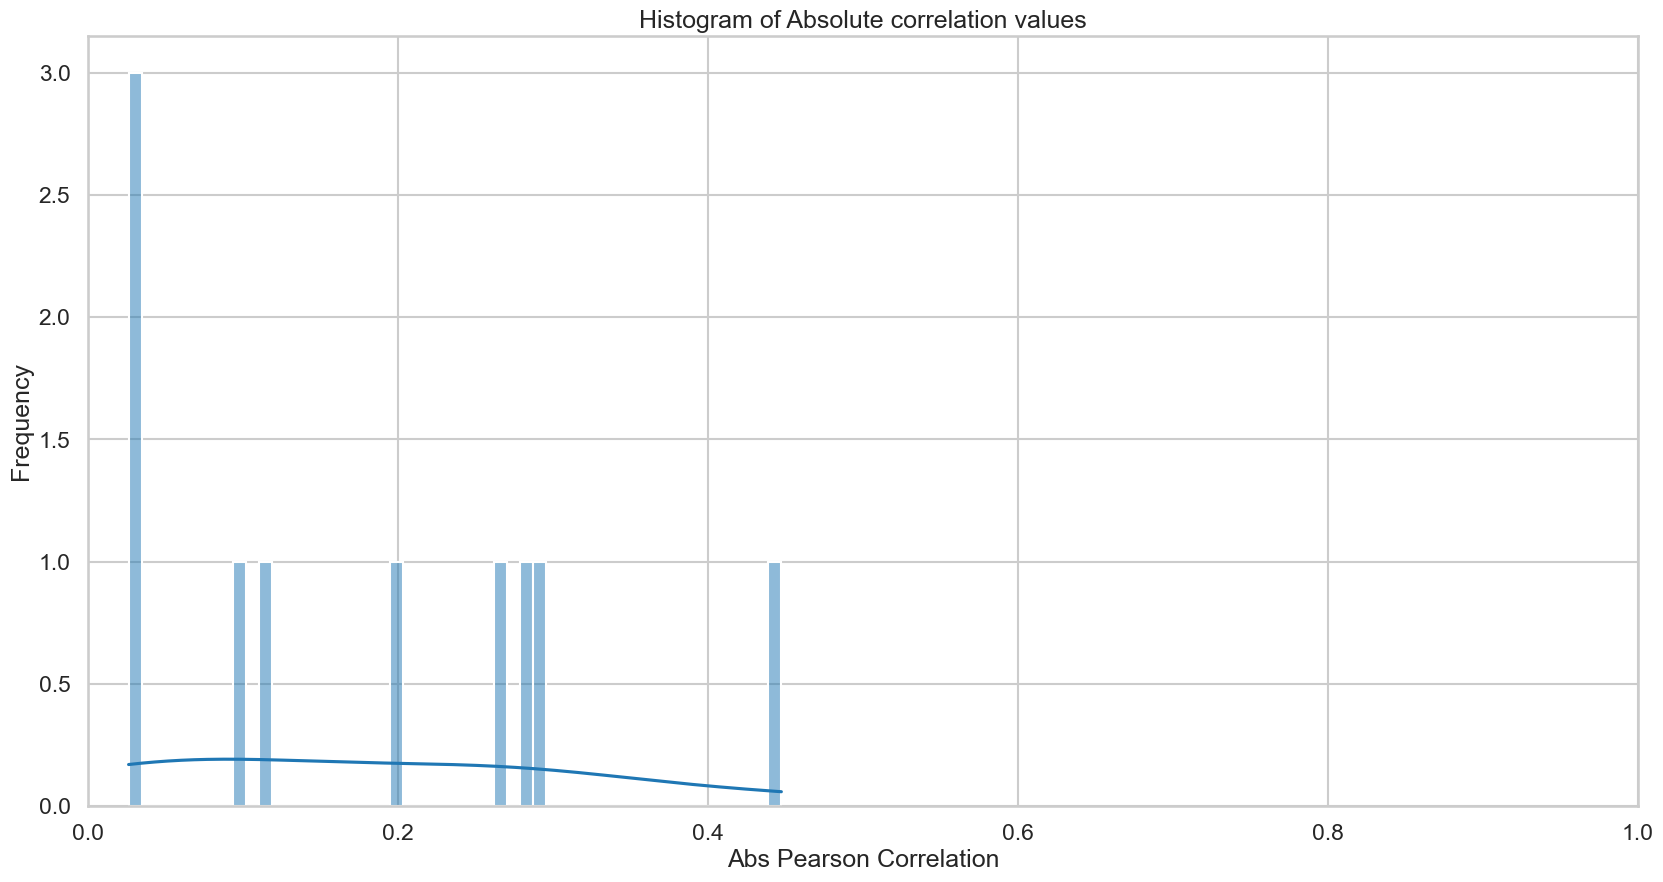

In [13]:
# make a histogram of the correlation values
plt.figure(figsize=(20, 10))
sns.histplot(abs_correlation_df['correlation'], bins=50, kde=True)
plt.title('Histogram of Absolute correlation values')
plt.xlabel('Abs Pearson Correlation')
plt.ylabel('Frequency')
plt.xlim(0,1)
plt.show()

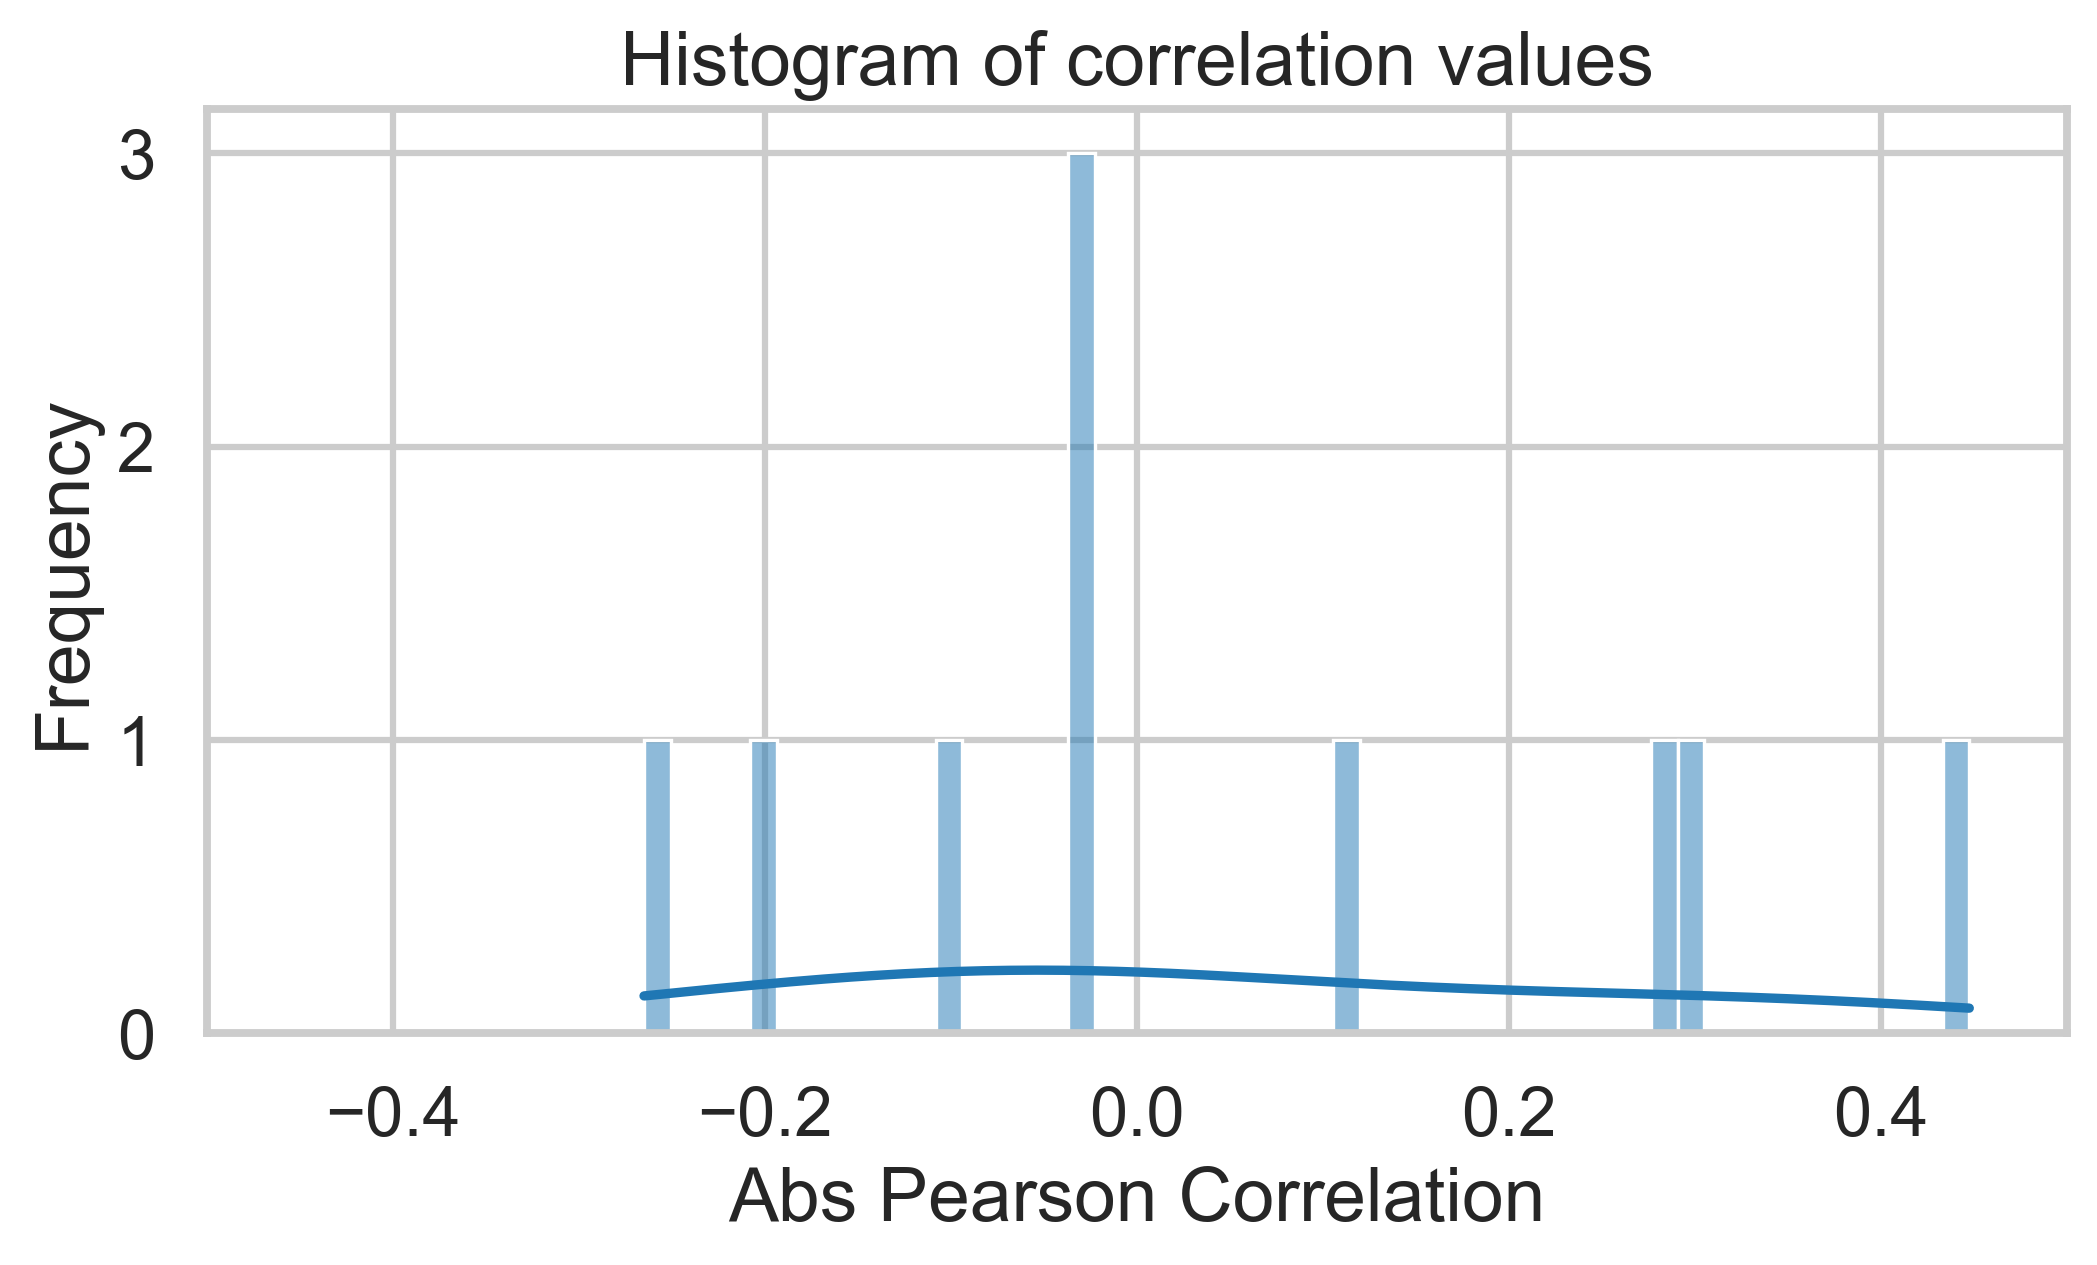

In [14]:
# make a histogram of the correlation values
sns.set_context("talk", rc={"font": "Arial"})
sns.set_style('whitegrid')
plt.figure(figsize=(8, 4), dpi=300)
sns.histplot(correlation_df['correlation'], bins=50, kde=True)
plt.title('Histogram of correlation values')
plt.xlabel('Abs Pearson Correlation')
plt.ylabel('Frequency')
plt.xlim(-0.5,0.5)
plt.show()

In [15]:
# extract the mean and standard deviation of the correlation values
mean = np.mean(correlation_df['correlation'])
std = np.std(correlation_df['correlation'])
max_val = np.max(correlation_df['correlation'])
min_val = np.min(correlation_df['correlation'])
outliers = correlation_df[(correlation_df['correlation'] > mean + 3*std) | (correlation_df['correlation'] < mean - 3*std)]

print(f'Mean: {mean:.4f}')
print(f'Standard Deviation: {std:.4f}')
print(f'Max: {max_val:.4f}')
print(f'Min: {min_val:.4f}')
print(f'Outliers as a ratio of all features: {outliers.shape[0] / correlation_df.shape[0]:.4f}')

Mean: 0.0492
Standard Deviation: 0.2186
Max: 0.4475
Min: -0.2650
Outliers as a ratio of all features: 0.0000


10 features selected based on correlation with target data


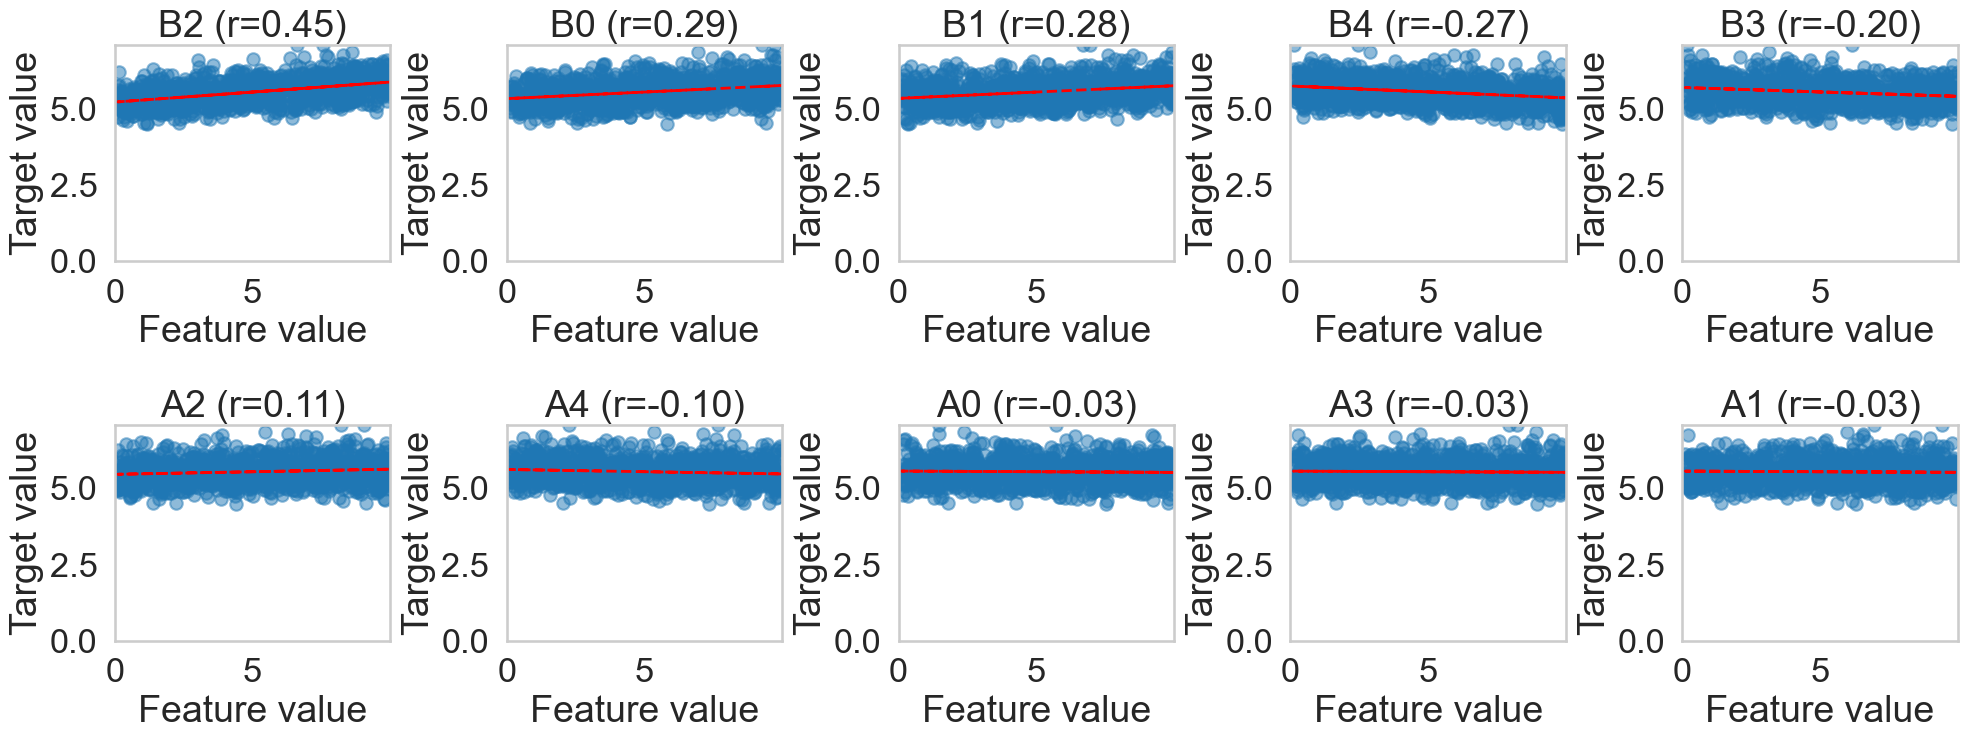

In [16]:
# plot association between the features and the target data 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for each feature, plot the association with the target data, which is only a series 
# plot all features in separate subplots
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.5) 

n_features = len(feature_data.columns)
# plot only the top 10 features based on the absolute correlation values
top_features = abs_correlation_df['feature'].values[:10]
# create a new dataframe with only the top features
top_feature_data = feature_data[top_features]
print(f'{len(top_feature_data.columns)} features selected based on correlation with target data')
# make a subplot based on the size of feature_data, have five columns and as many rows as needed
top_n_features = len(top_feature_data.columns)
n_rows = int(top_n_features / 5) if top_n_features % 5 == 0 else int(top_n_features / 5) + 1
n_cols = 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axs = axs.flatten()


# plot each feature in a separate subplot
for i, feature in enumerate(top_feature_data.columns):
    x = top_feature_data[feature].values.ravel()  # ensure 1D
    y = target_data.values.ravel()            # ensure 1D
    axs[i].scatter(x, y, alpha=0.5)
    # add a dash linear regression line with a pearson correlation coefficient
    # compute the pearson correlation coefficient
    corr, _ = pearsonr(x, y)
    # add a linear regression line
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    axs[i].plot(x, y_pred, color='red', linestyle='--', linewidth=2)
    axs[i].set_title(f'{feature} (r={corr:.2f})')

    axs[i].set_xlabel('Feature value')
    axs[i].set_ylabel('Target value')
    axs[i].grid()
    # set the x and y limits to be the same for all subplots
    max_feature = top_feature_data[feature].values.max()   
    max_target = target_data.values.max()  
    axs[i].set_xlim([0,max_feature])
    axs[i].set_ylim([0,max_target])
    # compute the correlation between the feature and target data
plt.tight_layout()
plt.show()

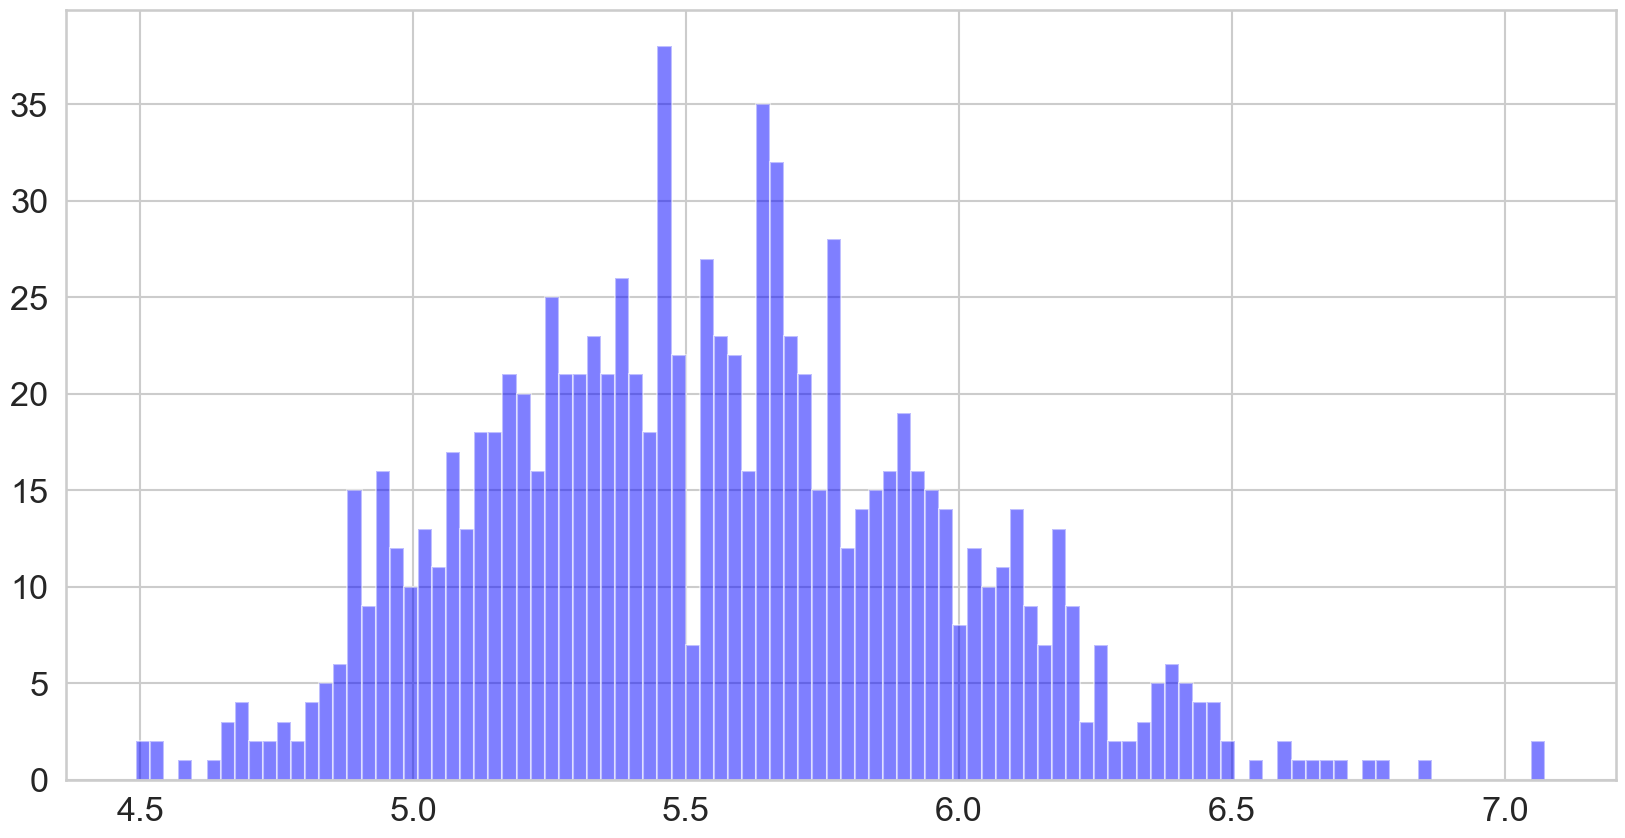

In [17]:
# plot the target data only with the x axis being 0 to 100 
plt.figure(figsize=(20, 10))
plt.hist(target_data, bins=100, alpha=0.5, color='blue')
plt.show()

### Suboptimal Model Creation

#### If modifying at the model architectural level

Mostly done to modify the `ModelSpec` object, where the updated spec information is transferred to a new `ModelBuilder` object, which then need to transpile to Antimony/SBML for a Solver instance. 

NewSpec --> NewBuilder --> Update parameters to original builder --> Transpile to Antimony/SBML --> Solver instance

#### If only changes to states and parameters are needed

Simply duplicate the `ModelBuilder` object and update the states and parameters.
```


#### Vary different specifications

In [18]:
# generate 1000 different model specifications, each  with a different random seed

spec_seeds = np.random.default_rng(o_random_seed).choice(range(1000000), 1000, replace=False).tolist()

diff_model_builds = []
for seed in spec_seeds:
    model_drug_spec = DrugModelSpecification()
    model_drug_spec.generate_specifications(seed, no_observable_species, no_feedback_regulations, verbose=0)
    drug_0 = Drug('D0', 500, 500)
    rng = np.random.default_rng(seed)
    # add random 'up' and 'down' regulations to the drug
    regulation_dir = []
    for i, s in enumerate(model_drug_spec.A_species):
        reg_type = str(rng.choice(['up', 'down']))
        regulation_dir.append(reg_type)
        drug_0.add_regulation(s, reg_type)
    model_drug_spec.add_drug(drug_0)
    G0_d = model_drug_spec.generate_network(f'drug_model_{seed}', 
                                            specie_value_range, 
                                            param_range, 
                                            param_multiplier_range,  
                                            verbose=0,
                                            random_seed=seed)
    diff_model_builds.append(G0_d)


#### If only changes to states and parameters are needed

In [19]:
# randomise links and parameters by using a different random seed

new_spec = DrugModelSpecification()
new_spec.generate_specifications(53252, 13, 0, verbose=0)
new_spec.add_drug(drug_0)
print(new_spec)
print(f'Feedback: {new_spec.get_feedback_regulations()}')

A Species: ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12']
C Species: ['C']
Regulations: [('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4'), ('A5', 'B5'), ('A6', 'B6'), ('A7', 'B7'), ('A8', 'B8'), ('A9', 'B9'), ('A10', 'B10'), ('A11', 'B11'), ('A12', 'B12'), ('B0', 'C'), ('B1', 'C'), ('B2', 'C'), ('B3', 'C'), ('B4', 'C'), ('B5', 'C'), ('B6', 'C'), ('B7', 'C'), ('B8', 'C'), ('B9', 'C'), ('B10', 'C'), ('B11', 'C'), ('B12', 'C'), ('D0', 'A0'), ('D0', 'A1'), ('D0', 'A2'), ('D0', 'A3'), ('D0', 'A4')]
Regulation Types: ['up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'up', 'down', 'down', 'down', 'down']
Drugs:
Drug(D0, 500, ['A0', 'A1', 'A2', 'A3', 'A4'], ['up', 'down', 'down', 'down', 'down'])

Feedback: []


In [20]:
new_model = new_spec.generate_network('drug_model_552', specie_value_range, param_range, param_multiplier_range, random_seed=100005352, verbose=0)
new_base_parameters = new_model.get_parameters()
new_base_initial_conditions = new_model.get_state_variables()

In [21]:
new_solver = RoadrunnerSolver()
new_solver.compile(new_model.get_sbml_model())
new_result = new_solver.simulate(0, 1000, 100)

In [22]:
# another spec with removed feedback regulations
from models.Utils import systematic_edge_pruning
new_spec_no_feedback, new_build_no_feedback, reg_deleted = systematic_edge_pruning(model_drug_spec, model_build, 10)
print(f'Removed {len(reg_deleted)} feedback regulations')
print(f'Regulations removed: {reg_deleted}')
print(new_spec_no_feedback)
new_base_parameters_no_feedback = new_build_no_feedback.get_parameters()
new_base_initial_conditions_no_feedback = new_build_no_feedback.get_state_variables()

Removed 10 feedback regulations
Regulations removed: [(('A4', 'B4'), 'up'), (('A1', 'B1'), 'up'), (('B2', 'C'), 'up'), (('A3', 'B3'), 'up'), (('B3', 'C'), 'up'), (('A0', 'B0'), 'up'), (('B1', 'C'), 'up'), (('B0', 'C'), 'up'), (('A2', 'B2'), 'up'), (('C', 'B2'), 'down')]
A Species: ['A0', 'A1', 'A2', 'A3', 'A4']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4']
C Species: ['C']
Regulations: [('B1', 'B2'), ('B4', 'C'), ('D0', 'A0'), ('D0', 'A1'), ('D0', 'A2'), ('D0', 'A3'), ('D0', 'A4')]
Regulation Types: ['down', 'down', 'up', 'down', 'down', 'down', 'down']
Drugs:
Drug(D0, 500, ['A0', 'A1', 'A2', 'A3', 'A4'], ['up', 'down', 'down', 'down', 'down'])



In [23]:
new_solver_no_feedback = RoadrunnerSolver()
new_solver_no_feedback.compile(new_build_no_feedback.get_sbml_model())

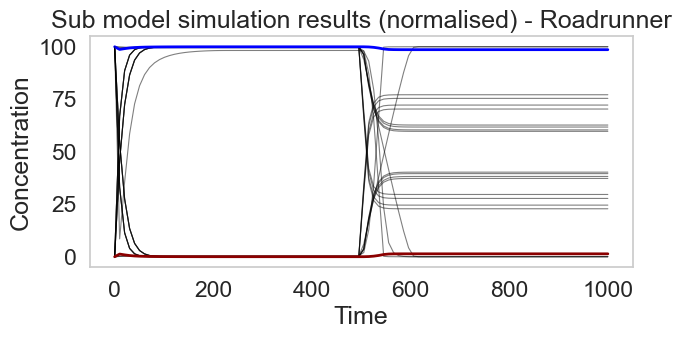

In [24]:
# use pandas default plot to plot the simulation results
import matplotlib.pyplot as plt
import seaborn as sns

states_variable_names = G0_d.get_state_variables()
result = new_result

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)
# set font to 'Arial'
plt.rcParams['font.family'] = 'Arial'

# Plot the simulation results
plt.figure(figsize=(7, 3))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Sub model simulation results (normalised) - Roadrunner')
plt.grid()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

### Simulation / Extract dynamic feature data

In [25]:
# Minor distortion of the parameters to create a new set of parameters

rng = np.random.default_rng(o_random_seed)
modified_parameter_sets = []
for params in parameter_sets:
    new_params = {}
    for key, value in params.items(): 
        new_params[key] = value * rng.uniform(0.25, 4) # distortion range, expectation is that the larger the worse the model performance 
    modified_parameter_sets.append(new_params)

In [26]:
params_for_topology = deepcopy(parameter_sets)
for param_set in params_for_topology: 
    # cross-check with 'new_base_parameters', remove the parameters that are not in 'new_base_parameters'
    for key in list(param_set.keys()):
        if key not in new_base_parameters:
            del param_set[key]
        

In [27]:
from models.SyntheticGen import generate_model_timecourse_data, generate_model_timecourse_data_diff_build

new_base_parameters_set = []
for p in p_random_seeds: 
    new_base_parameters_set.append(new_base_parameters)

# generate the timecourse data for the new model
time_course_data = generate_model_timecourse_data_diff_build(new_spec, 
                                                  new_solver, 
                                                  feature_data, 
                                                  params_for_topology,
                                                  {'start': 0, 'end': 1000, 'points': 100}, 
                                                  capture_species='all', n_cores=1, verbose=True)


Simulating perturbations: 100%|██████████| 1000/1000 [00:16<00:00, 59.23it/s]


In [28]:
true_time_course_data = generate_model_timecourse_data_diff_build(model_drug_spec, 
                                                            solver,
                                                            feature_data, 
                                                            parameter_sets, 
                                                            {'start': 0, 'end': 1000, 'points': 100}, 
                                                            capture_species='all', n_cores=1, verbose=True)

Simulating perturbations: 100%|██████████| 1000/1000 [00:06<00:00, 144.42it/s]


In [29]:
# generate the timecourse data for the new model
param_time_course_data = generate_model_timecourse_data_diff_build(model_drug_spec, 
                                                  solver, 
                                                  feature_data, 
                                                  modified_parameter_sets,
                                                  {'start': 0, 'end': 1000, 'points': 100}, 
                                                  capture_species='all', n_cores=1, verbose=True)

Simulating perturbations: 100%|██████████| 1000/1000 [00:06<00:00, 154.75it/s]


In [30]:
# from models.SyntheticGen import generate_model_timecourse_data_diff_spec

# topology_time_course_data = generate_model_timecourse_data_diff_spec(diff_model_builds,
#                                                                      RoadrunnerSolver,
#                                                                         feature_data, 
#                                                                         {'start': 0, 'end': 1000, 'points': 100},
#                                                                         capture_species='all', n_cores=1, verbose=True)

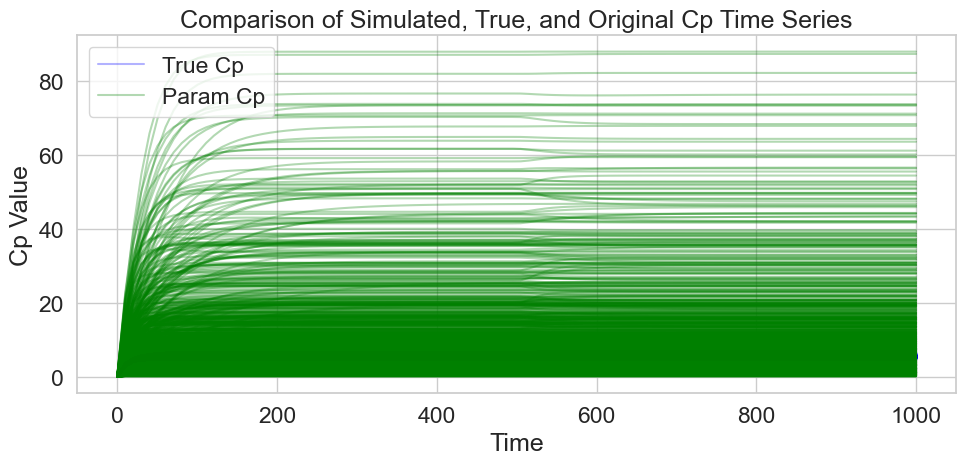

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Get time axis (assuming same length for both datasets)
n_steps = len(time_course_data['Cp'][0])
real_time = np.linspace(0, 1000, n_steps)

plt.figure(figsize=(10, 5))

# Plot true time course (blue)
for series in true_time_course_data['Cp']:
    plt.plot(real_time, series, alpha=0.3, color='blue', label='True Cp' if 'True Cp' not in plt.gca().get_legend_handles_labels()[1] else "")
    
for series in param_time_course_data['Cp']:
    plt.plot(real_time, series, alpha=0.3, color='green', label='Param Cp' if 'Param Cp' not in plt.gca().get_legend_handles_labels()[1] else "")
    
# for series in topology_time_course_data['Cp']:
#     plt.plot(real_time, series, alpha=0.3, color='black', label='Topology Cp' if 'Topology Cp' not in plt.gca().get_legend_handles_labels()[1] else "")

# Labels and formatting
plt.title("Comparison of Simulated, True, and Original Cp Time Series")
plt.xlabel("Time")
plt.ylabel("Cp Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


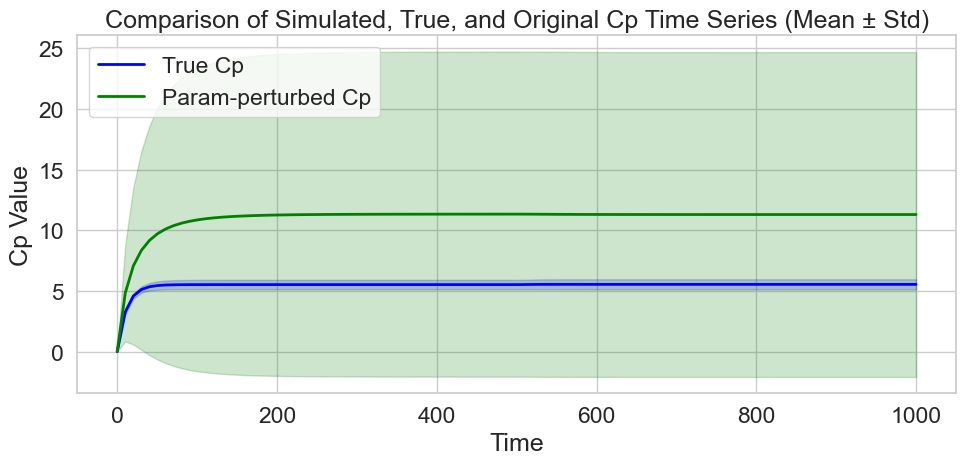

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# === Set up time axis ===
n_steps = len(time_course_data['Cp'][0])  # assumes all rows have equal length
real_time = np.linspace(0, 1000, n_steps)

# === Helper function to plot mean ± std ===
def plot_mean_std(df, color, label, time_axis):
    # Stack rows of lists into a 2D array: shape (n_replicates, time_steps)
    data = np.vstack(df['Cp'].values)
    mean = data.mean(axis=0)
    std = data.std(axis=0)

    # Plot mean line
    plt.plot(time_axis, mean, color=color, label=label, linewidth=2)
    # Plot shaded std band
    plt.fill_between(time_axis, mean - std, mean + std, color=color, alpha=0.2)

# === Begin Plot ===
plt.figure(figsize=(10, 5))

# Plot mean ± std for true data
plot_mean_std(true_time_course_data, color='blue', label='True Cp', time_axis=real_time)

# Plot mean ± std for parameter-modified data
plot_mean_std(param_time_course_data, color='green', label='Param-perturbed Cp', time_axis=real_time)

# Plot mean ± std for topology-modified data
# plot_mean_std(topology_time_course_data, color='black', label='Topology-modified Cp', time_axis=real_time)

# === Plot Settings ===
plt.title("Comparison of Simulated, True, and Original Cp Time Series (Mean ± Std)")
plt.xlabel("Time")
plt.ylabel("Cp Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
from models.Utils import last_time_point_method, dynamic_features_method

all_species = model_drug_spec.A_species + model_drug_spec.B_species + model_drug_spec.C_species
all_phos_species = [s+'p' for s in all_species]
# apply the data engineering method to the feature data
last_time_data = last_time_point_method(param_time_course_data, all_phos_species)

In [34]:
dynamic_data = dynamic_features_method(param_time_course_data, all_phos_species, n_cores=8)

In [35]:
combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)


In [36]:
feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']

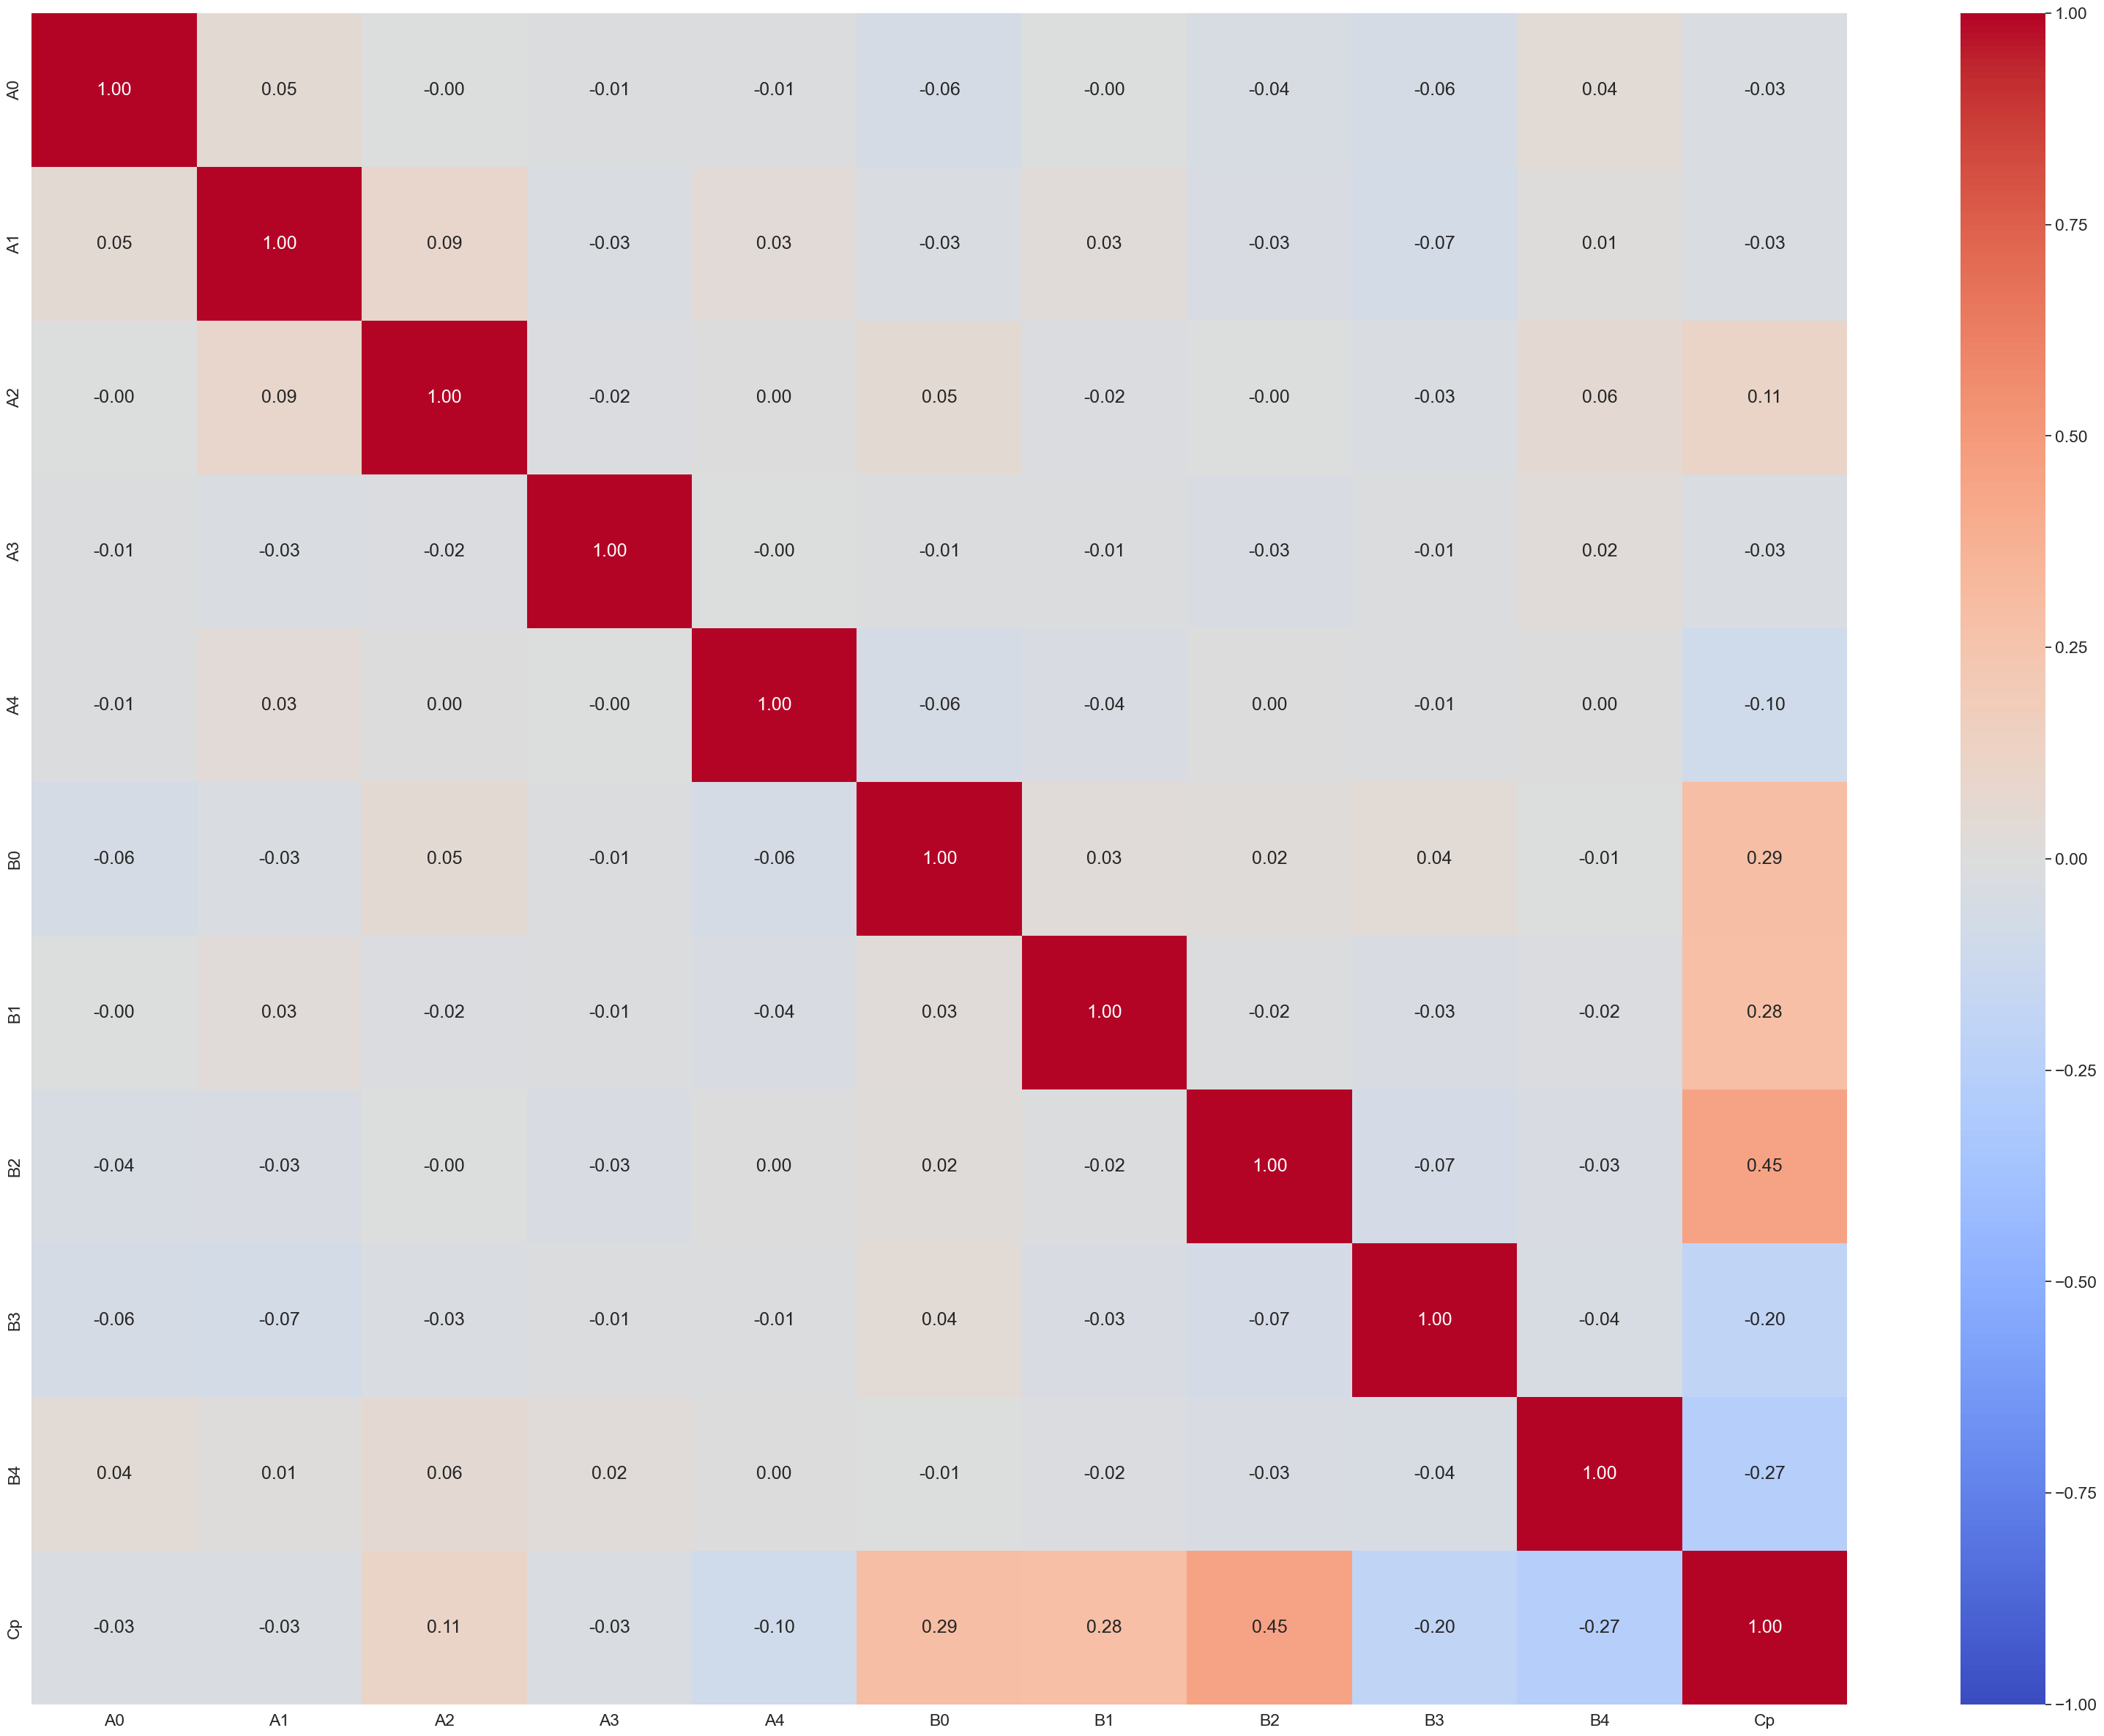

In [37]:
import seaborn as sns
feature_target_df = feature_data.copy()
feature_target_df['Cp'] = target_data['Cp']
plt.figure(figsize=(40, 30))
sns.heatmap(feature_target_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.show()

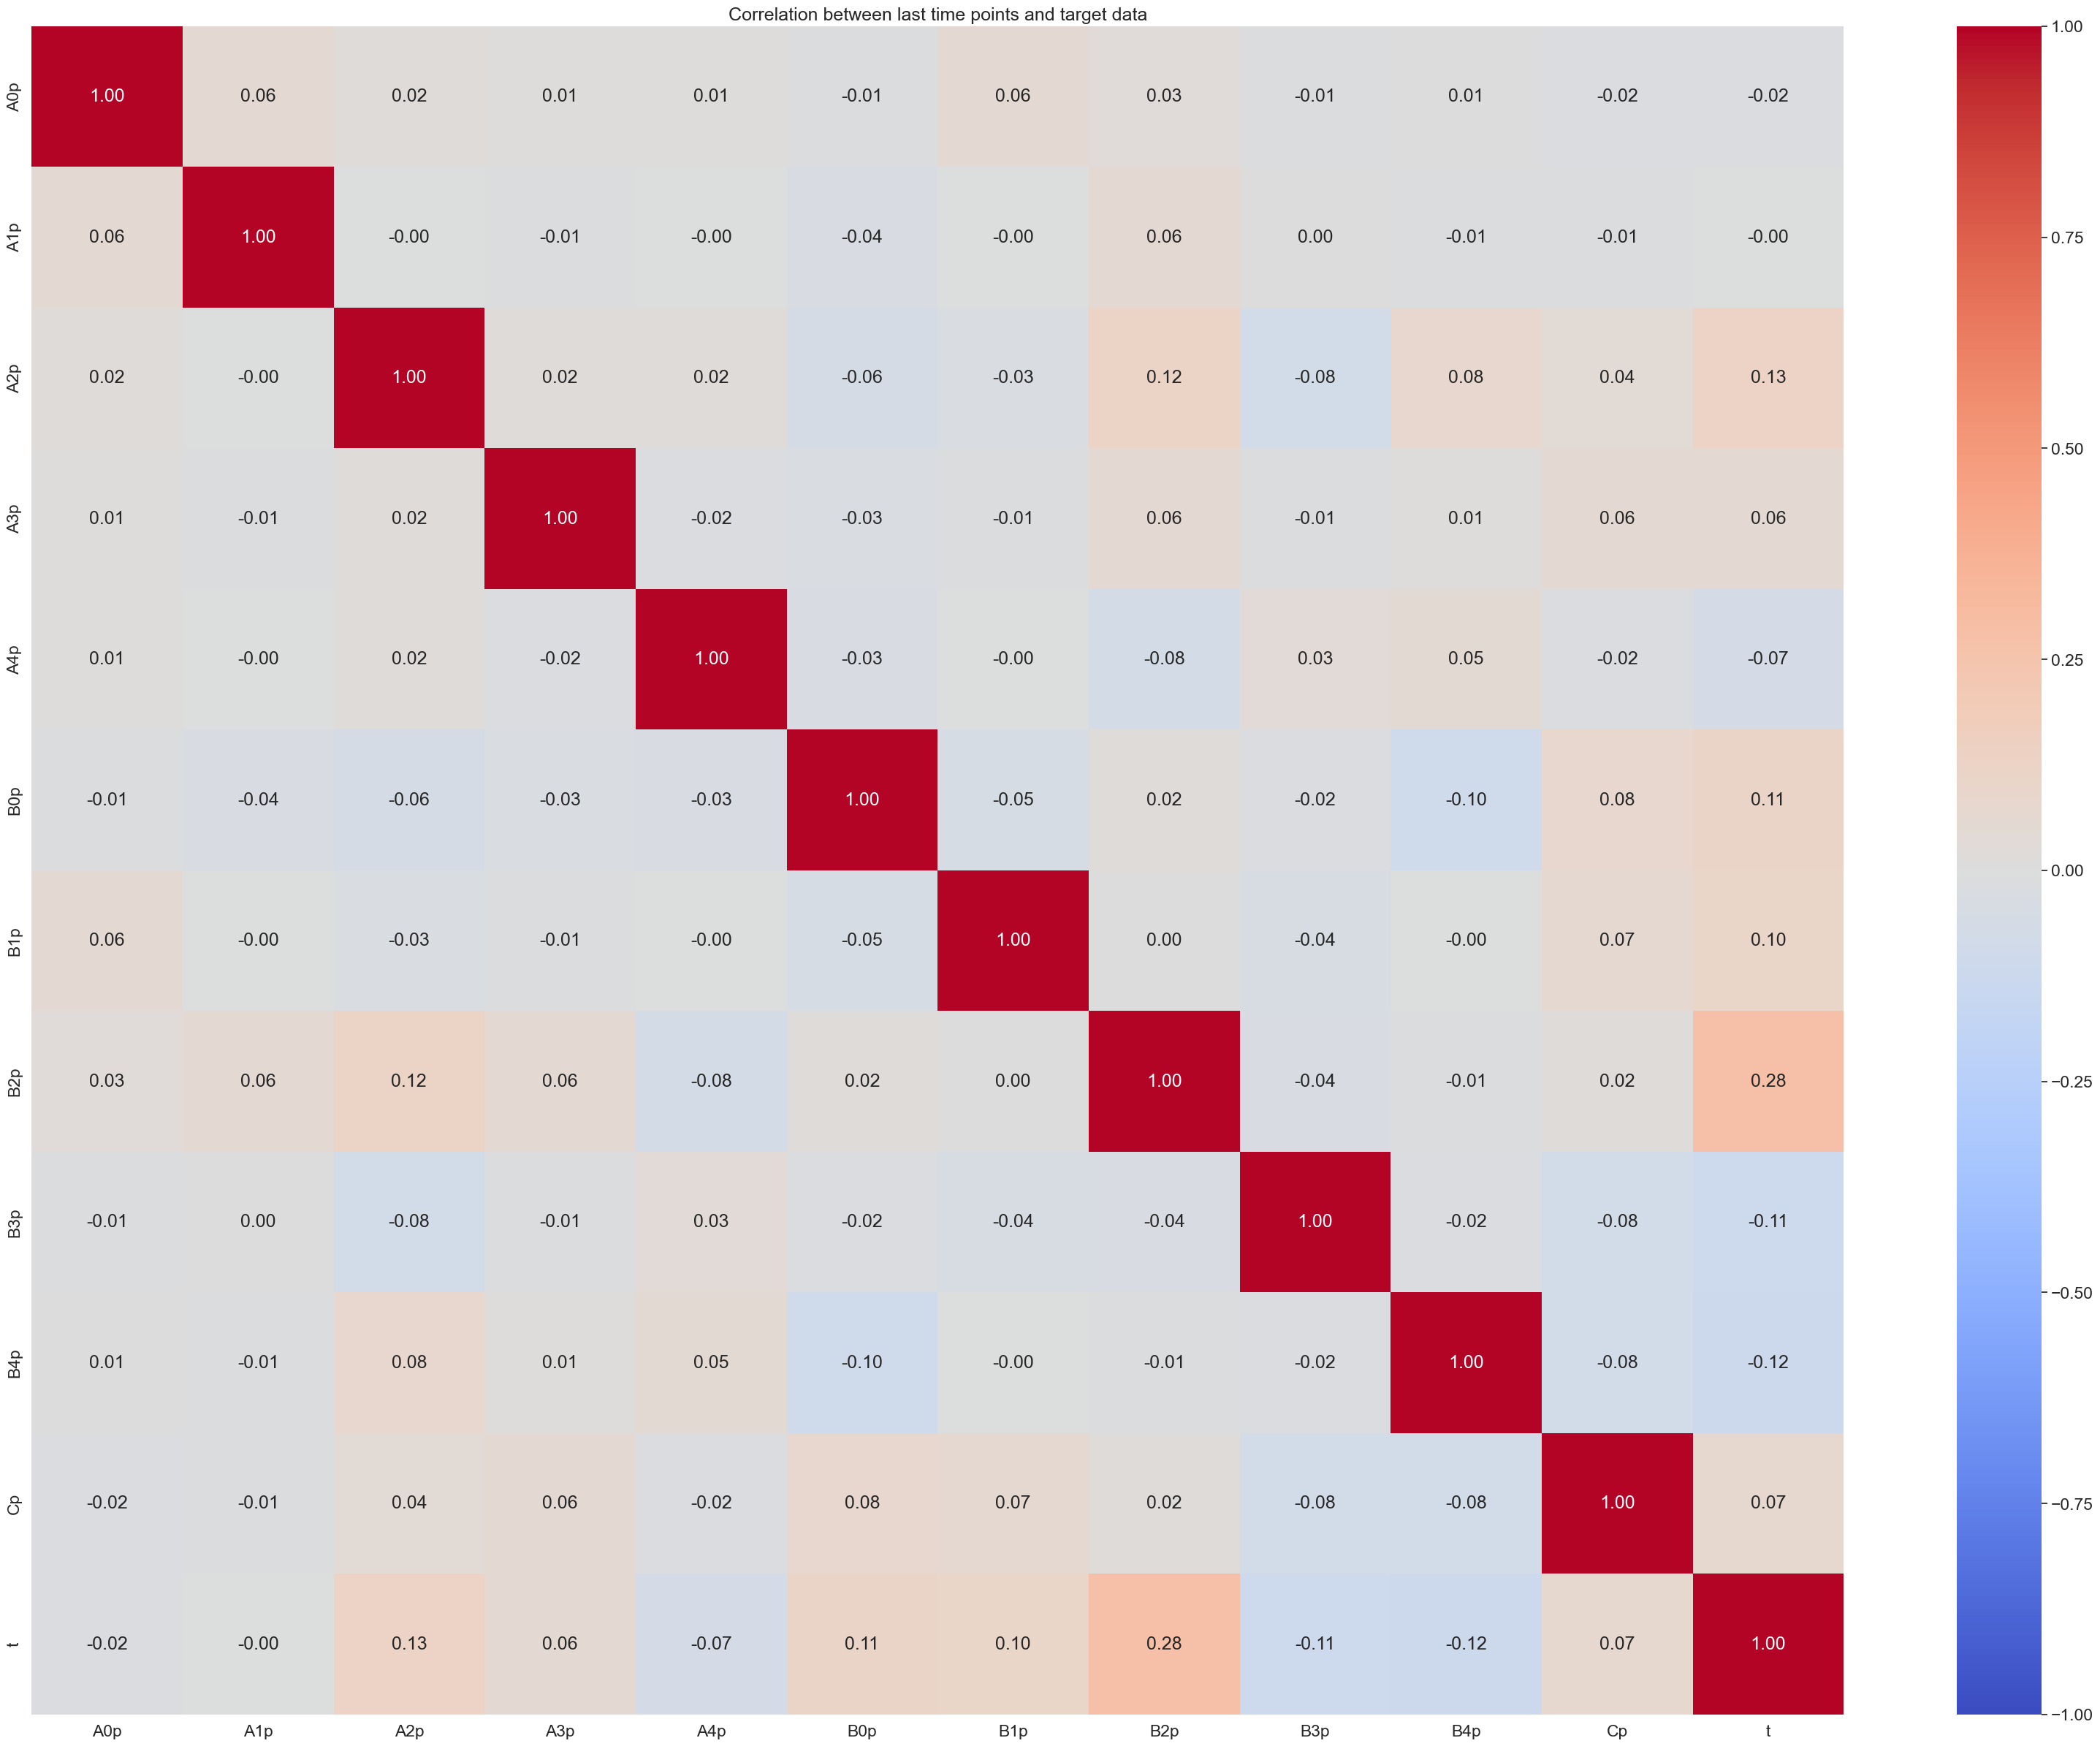

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
# perform correlation analysis between the last time points and the target data
target_last_time_points_S0 = last_time_data.copy()
target_last_time_points_S0['t'] = target_data['Cp']
plt.figure(figsize=(40, 30))
# ensure color map is consistent with the previous heatmap
sns.heatmap(target_last_time_points_S0.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation between last time points and target data')
plt.show()

### Machine Learning Training

In [39]:
from sklearn.inspection import permutation_importance


def evaluate_model(model, model_name, feature_data, feature_data_name, target_data, test_size=0.2, random_state=4):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=random_state, n_jobs=1)
    feature_names = feature_data.columns
    # return a dictionary of the model performance
    return {'Model': model_name, 
            'Feature Data': feature_data_name,
            'Mean Squared Error': mean_squared_error(y_test, y_pred),
            'R2 Score': r2_score(y_test, y_pred),
            'Pearson Correlation': pearsonr(y_test, y_pred)[0],
            'Pearson P-Value': pearsonr(y_test, y_pred)[1],
            'Permutation Importance': result,
            'Feature Names': feature_names,
            }
# create a linear regression model
lm = LinearRegression()
# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=o_random_seed)
# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=o_random_seed)
# create a support vector machine model
svr = SVR(max_iter=10000)
scaled_svr = Pipeline([('scaler', StandardScaler()), ('svr', svr)])
# create a neural network model (simple)
nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=o_random_seed)
scaled_nn = Pipeline([('scaler', StandardScaler()), ('nn', nn)])

all_models = [lm, rf, gb, scaled_svr, scaled_nn]
all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
zipped_model_data = list(zip(all_models, all_models_desc))
all_features = feature_data_list
all_features_desc = feature_data_names
zipped_feature_data = list(zip(all_features, all_features_desc))

# random states are rand ints between 0 and 10000, for n values 
np.random.seed(o_random_seed)
n_random = 10
all_random_states = np.random.randint(0, 10000, n_random)

parallelise = True 
from tqdm import tqdm
# tqdm is a progress bar library, use it to show the progress of the model evaluation
metric_data = []
if not parallelise:          
    for (feature_data, feature_data_name) in tqdm(zipped_feature_data):
        # print('Feature Data:', feature_data_name)
        # print('Feature Data Shape:', feature_data.shape)
        for (model, model_name) in zipped_model_data:
            # print('Model:', model_name)
            for rand in all_random_states:
                metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand)
                metric_data.append(metrics)
                
else:        
    # parallelise the model evaluation process using joblib
    from joblib import Parallel, delayed

    metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand) 
                                    for (feature_data, feature_data_name) in zipped_feature_data
                                    for (model, model_name) in zipped_model_data
                                    for rand in all_random_states)

# make a dataframe of the metric data
metric_df = pd.DataFrame(metric_data)
metric_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value,Permutation Importance,Feature Names
0,Linear Regression,feature_data,0.085693,0.528026,0.727147,3.484323e-34,"{'importances_mean': [-1.2875543712764781e-05,...","Index(['A0', 'A1', 'A2', 'A3', 'A4', 'B0', 'B1..."
1,Linear Regression,feature_data,0.090880,0.484879,0.703100,3.846450e-31,"{'importances_mean': [-0.00052888259527899, 0....","Index(['A0', 'A1', 'A2', 'A3', 'A4', 'B0', 'B1..."
2,Linear Regression,feature_data,0.091075,0.491285,0.702889,4.077318e-31,"{'importances_mean': [-0.0020423821521168284, ...","Index(['A0', 'A1', 'A2', 'A3', 'A4', 'B0', 'B1..."
3,Linear Regression,feature_data,0.093715,0.473140,0.688187,2.104442e-29,"{'importances_mean': [-0.001061438798600134, 0...","Index(['A0', 'A1', 'A2', 'A3', 'A4', 'B0', 'B1..."
4,Linear Regression,feature_data,0.085751,0.479116,0.695502,3.046554e-30,"{'importances_mean': [-2.5351013543595256e-05,...","Index(['A0', 'A1', 'A2', 'A3', 'A4', 'B0', 'B1..."
...,...,...,...,...,...,...,...,...
245,Neural Network,combined_dyn_data,0.912780,-4.786852,0.200129,4.492822e-03,"{'importances_mean': [-0.08055074562917772, -0...","Index(['A0', 'A1', 'A2', 'A3', 'A4', 'B0', 'B1..."
246,Neural Network,combined_dyn_data,0.658708,-2.452161,0.460785,6.612196e-12,"{'importances_mean': [0.026044442706451943, 0....","Index(['A0', 'A1', 'A2', 'A3', 'A4', 'B0', 'B1..."
247,Neural Network,combined_dyn_data,0.692274,-3.386992,0.210611,2.758303e-03,"{'importances_mean': [0.14658823626077444, -0....","Index(['A0', 'A1', 'A2', 'A3', 'A4', 'B0', 'B1..."
248,Neural Network,combined_dyn_data,0.710987,-3.521145,0.173711,1.389459e-02,"{'importances_mean': [-0.029934290561094378, 0...","Index(['A0', 'A1', 'A2', 'A3', 'A4', 'B0', 'B1..."


In [40]:
if save_figures: 
    metric_df.to_pickle(experiment_folder+'metric_df.pkl')
    print('Metric data saved to:', experiment_folder+'metric_df.pkl')   


Metric data saved to: C:\Users\dawson\Documents\Google Drive\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp18_model_topology_5__50/metric_df.pkl


In [41]:
# load the metric data
import pandas as pd 
metric_df = pd.read_pickle(experiment_folder+'metric_df.pkl')
print('Metric data loaded from:', experiment_folder+'metric_df.pkl')

Metric data loaded from: C:\Users\dawson\Documents\Google Drive\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp18_model_topology_5__50/metric_df.pkl


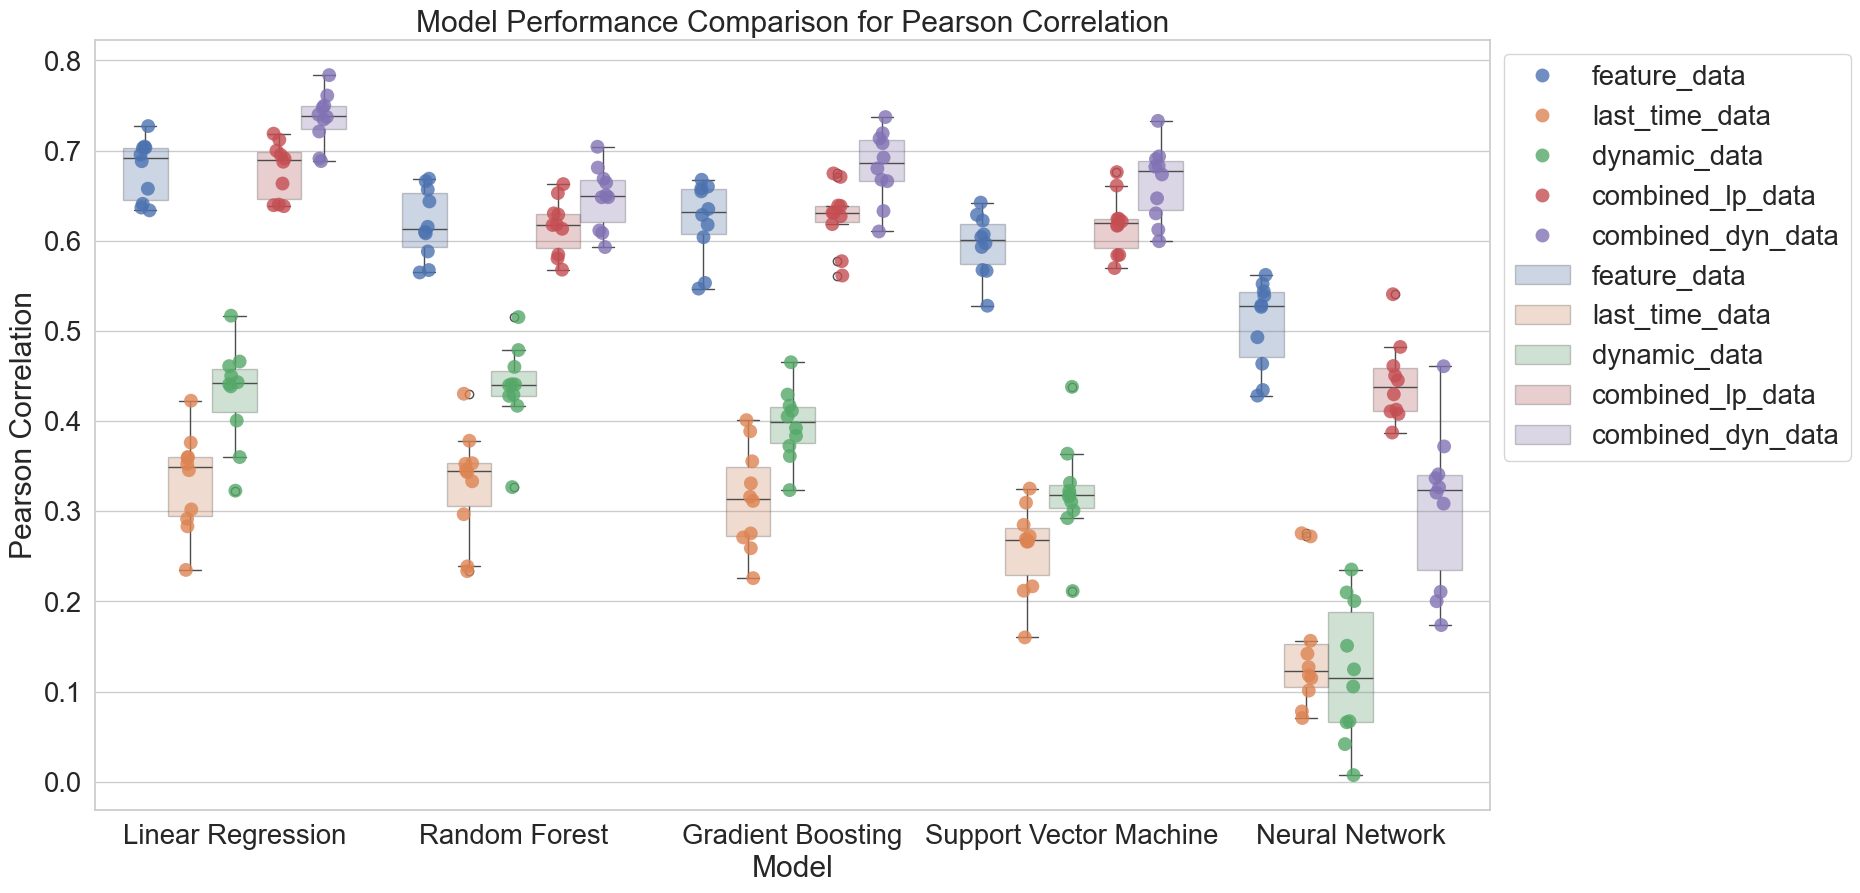

In [42]:
# create box plots for each model type and feature data type, plot for pearson correlation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)
    

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Pearson Correlation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

if save_figures:
    plt.savefig(experiment_folder + 'Fig_13_model_performance_comparison_pearson.png')
plt.show()

In [49]:
# plot 'Permutation Importance' for a specific model and feature data type
def plot_permutation_importance(metric_df, model_name, feature_data_name):
    # filter the metric_df for the specific model and feature data type
    filtered_df = metric_df[(metric_df['Model'] == model_name) & (metric_df['Feature Data'] == feature_data_name)]
    
    # extract the permutation importance values
    perm_importance = filtered_df['Permutation Importance'].values[0]
    
    # extract the feature names from the filtered_df
    feature_names = filtered_df['Feature Names'].values[0]

    # create a dataframe for the permutation importance values
    perm_importance_df = pd.DataFrame(perm_importance.importances_mean, index=feature_names, columns=['Importance']).reset_index()
    perm_importance_df.columns = ['Feature', 'Importance']
    
    # sort the dataframe by importance
    perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)
    
    # plot the permutation importance values
    plt.figure(figsize=(10, 6))
    sns.barplot(data=perm_importance_df.head(20), x='Importance', y='Feature', palette='viridis', hue='Feature')
    plt.title(f'Permutation Importance for {model_name} with {feature_data_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    
    if save_figures:
        plt.savefig(experiment_folder + f'Fig_14_permutation_importance_{model_name}_{feature_data_name}.png')
    
    plt.show()

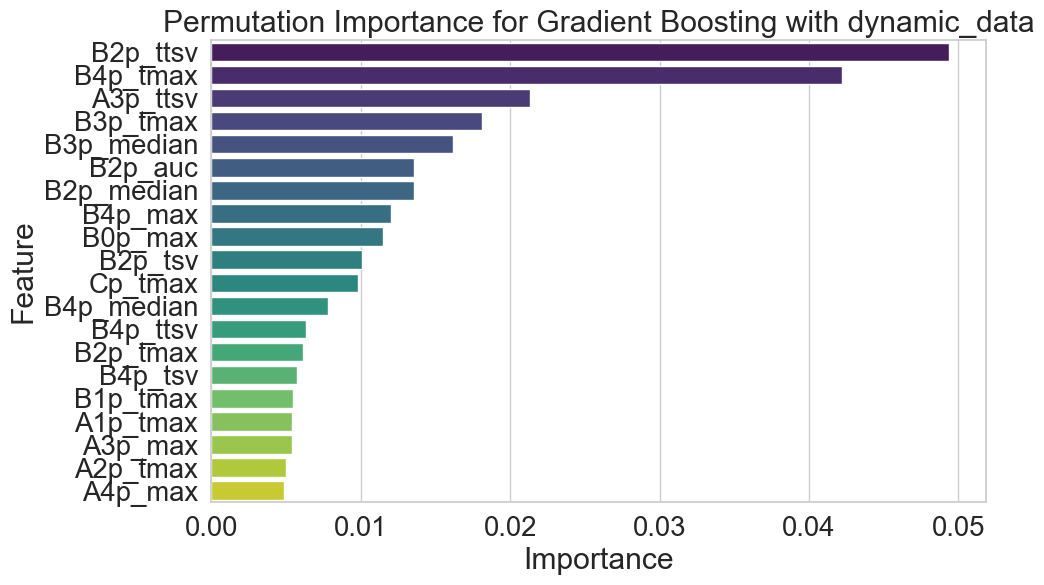

In [57]:
plot_permutation_importance(metric_df, 'Gradient Boosting', 'dynamic_data')

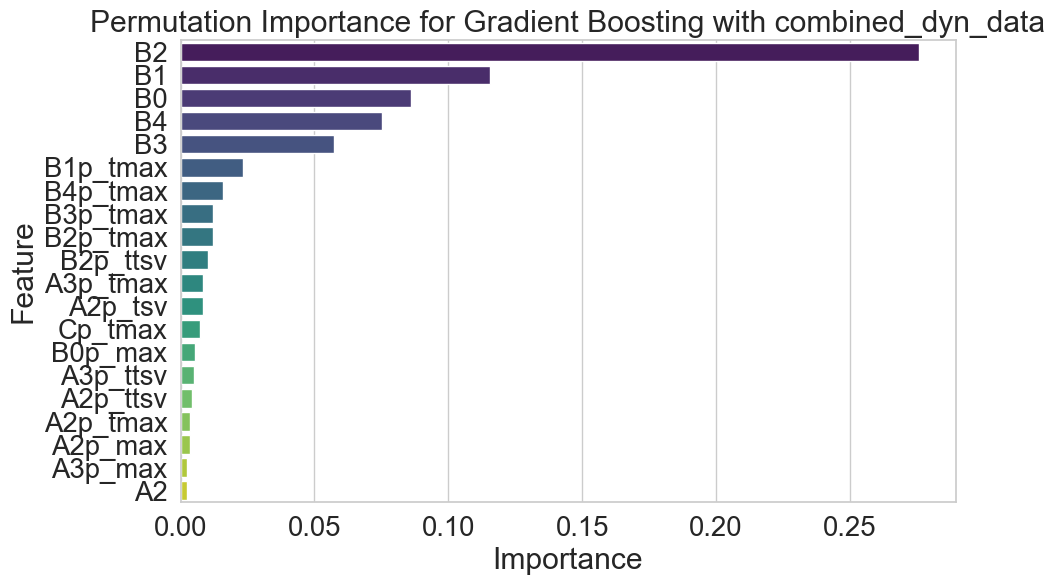

In [56]:
plot_permutation_importance(metric_df, 'Gradient Boosting', 'combined_dyn_data')

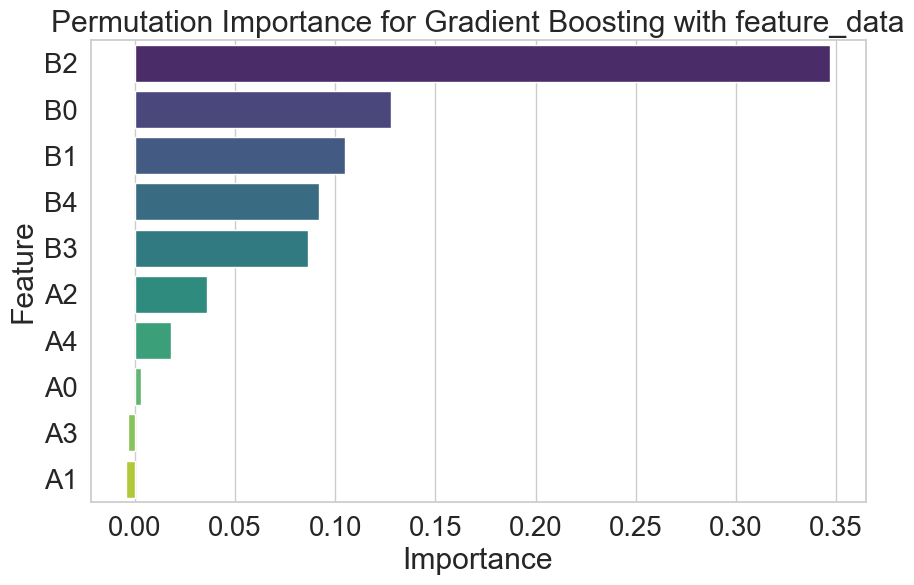

In [58]:
plot_permutation_importance(metric_df, 'Gradient Boosting', 'feature_data')

Model performance box plot saved to: C:\Users\dawson\Documents\Google Drive\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp18_model_topology_5__50/Boxplot_with_model_shapes.png


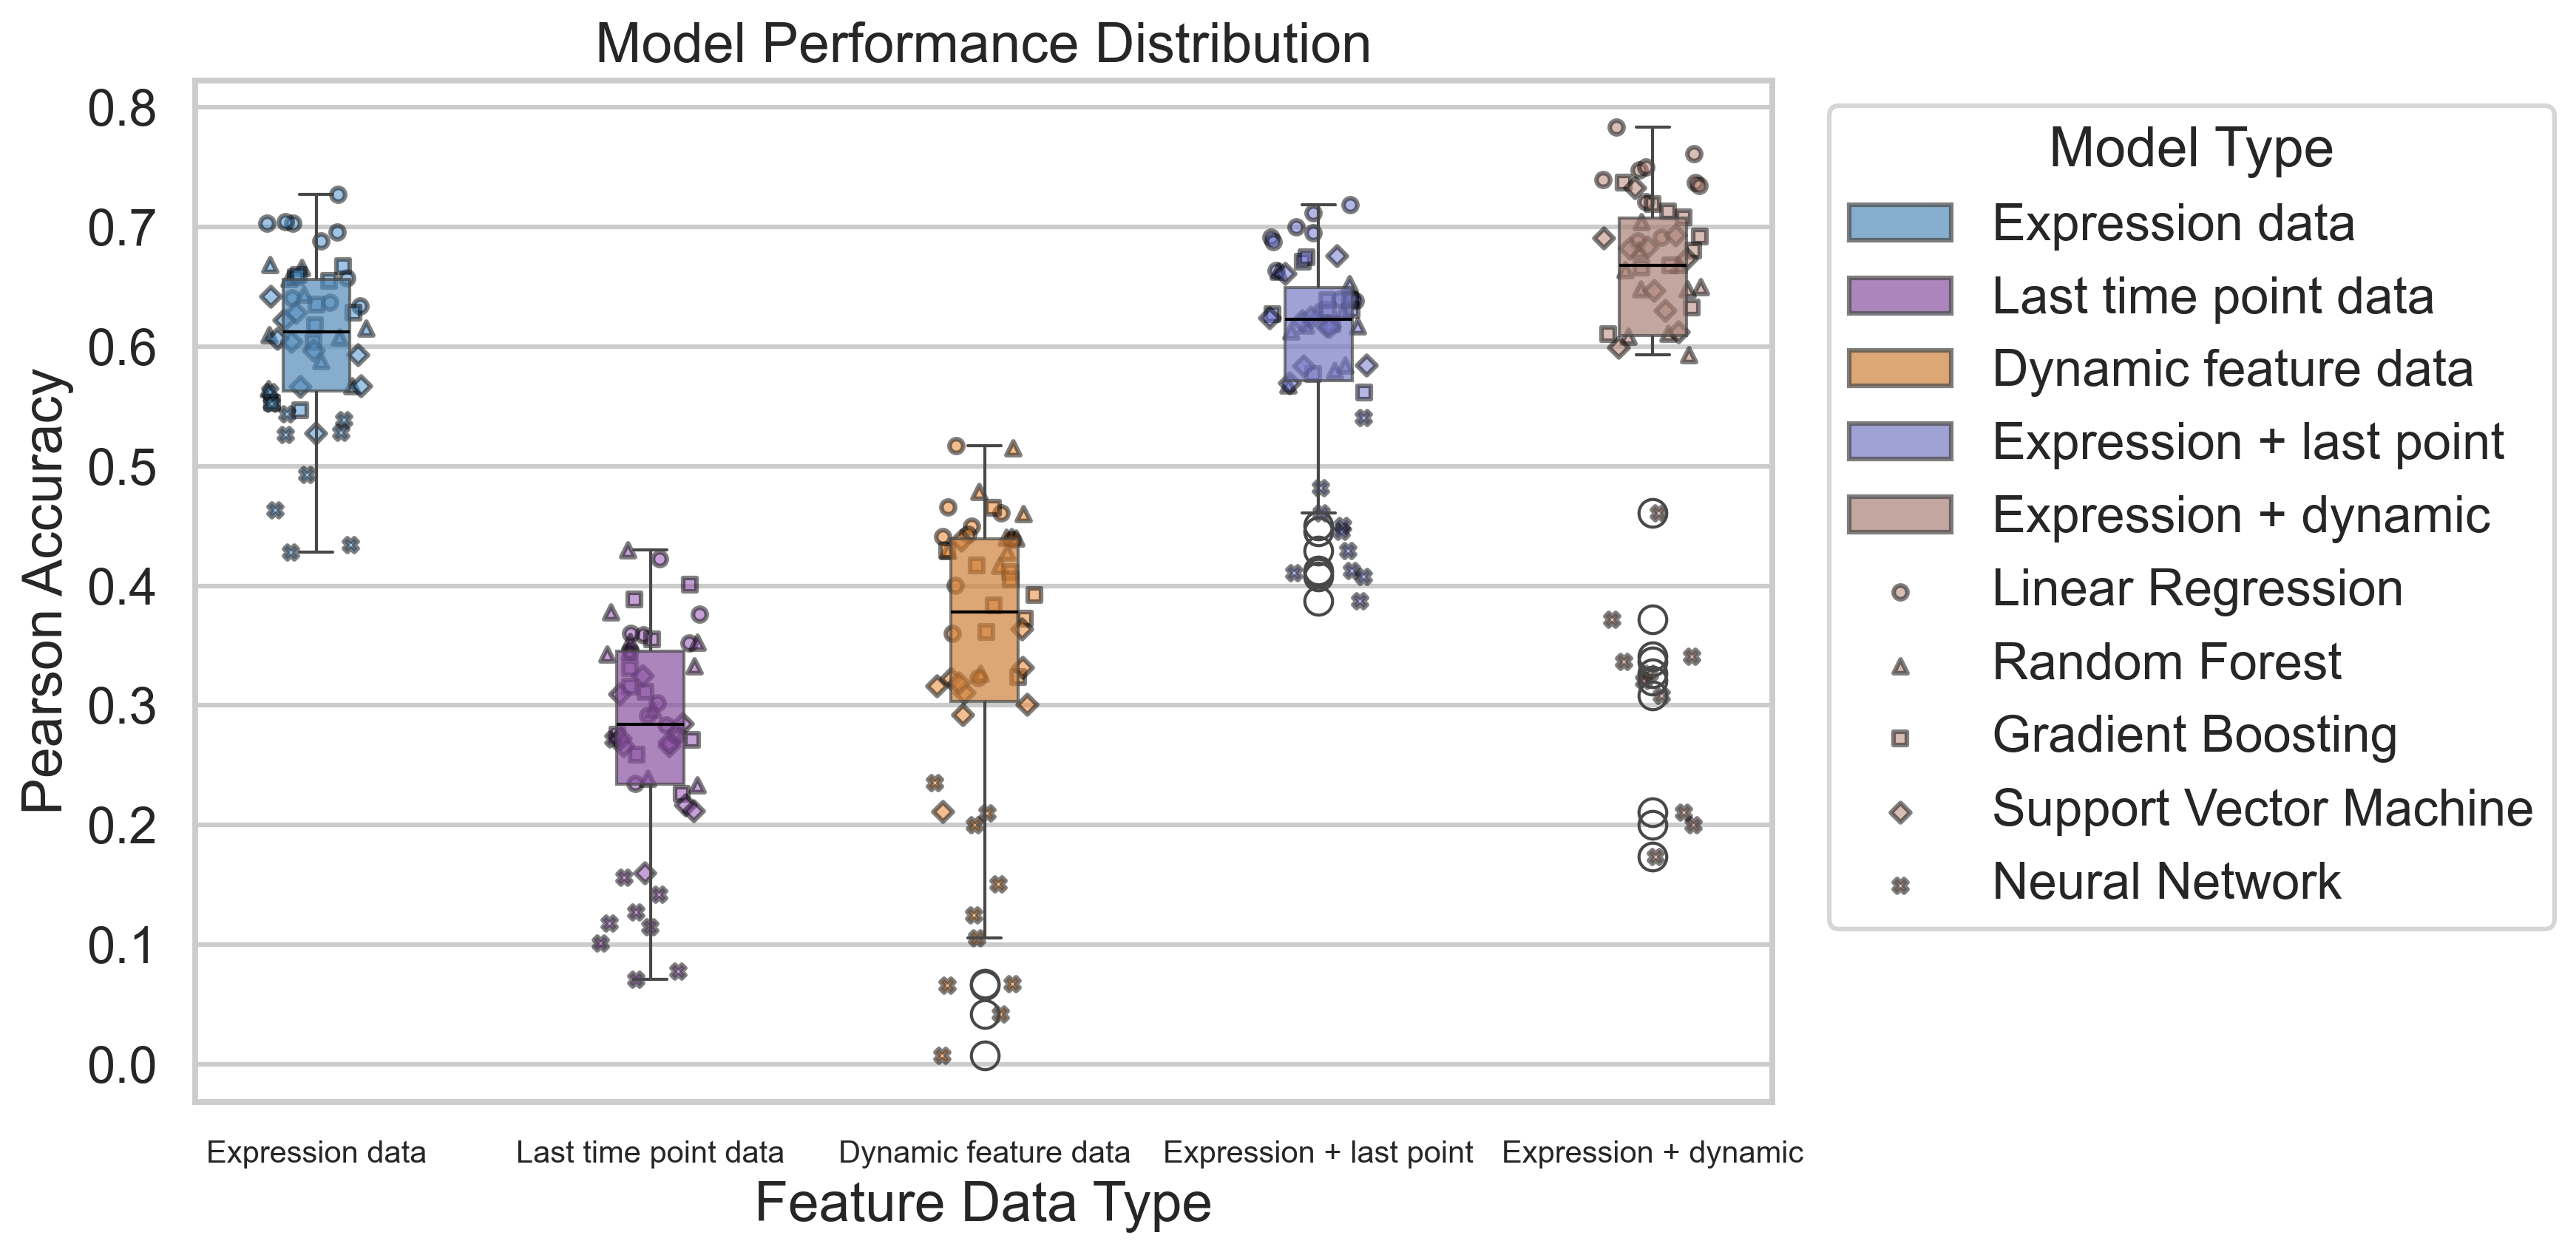

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np

# Define custom markers for each model
model_markers = {
    'Linear Regression': 'o',
    'Random Forest': '^',
    'Gradient Boosting': 's',
    'Support Vector Machine': 'D',
    'Neural Network': 'X'
}

# Color map for feature data types
color_map = {
    'Expression data': '#428bca',
    'Last time point data': '#8e44ad',
    'Dynamic feature data': '#e67e22',
    'Expression + last point': '#6b6fcf',
    'Expression + dynamic': '#b07c6f'
}

# Preprocess data
plot_data = metric_df.copy()
plot_data['Feature Data'] = plot_data['Feature Data'].replace({
    'feature_data': 'Expression data',
    'last_time_data': 'Last time point data',
    'dynamic_data': 'Dynamic feature data',
    'combined_lp_data': 'Expression + last point',
    'combined_dyn_data': 'Expression + dynamic',
    'combined expression + last time point': 'Expression + last point',
    'combined expression + dynamic feature': 'Expression + dynamic'
})


# Get consistent order for feature types
feature_order = list(color_map.keys())

# Plot setup
plt.figure(figsize=(12, 6), dpi=300)
sns.set_context("talk", font_scale=1)
sns.set_style("whitegrid")
matplotlib.rcParams['font.family'] = 'Arial'

# Boxplot
ax = sns.boxplot(
    data=plot_data,
    x='Feature Data',
    y='Pearson Correlation',
    hue='Feature Data',            # Explicitly assign hue
    palette=color_map,
    width=0.2,
    showcaps=True,
    boxprops={'alpha': 0.7},
    medianprops={'color': 'black'},
    legend=True                   # Suppress duplicate legend
)

# Overlay points with custom markers per model
x_positions = {cat: i for i, cat in enumerate(feature_order)}

for model_name, marker in model_markers.items():
    subset = plot_data[plot_data['Model'] == model_name]
    for _, row in subset.iterrows():
        x = x_positions[row['Feature Data']] + np.random.uniform(-0.15, 0.15)
        y = row['Pearson Correlation']
        ax.scatter(x, y,
                   color=color_map[row['Feature Data']],
                   marker=marker,
                   s=20,
                   edgecolor='black',
                   alpha=0.5,
                   label=model_name)

# De-duplicate model legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title="Model Type", bbox_to_anchor=(1.02, 1), loc='upper left')

# Axis styling
plt.title('Model Performance Distribution')
plt.xlabel('Feature Data Type')
plt.ylabel('Pearson Accuracy')
plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()

if save_figures:
    plt.savefig(experiment_folder + 'Boxplot_with_model_shapes.png')
    print('Model performance box plot saved to:', experiment_folder + 'Boxplot_with_model_shapes.png')

plt.show()


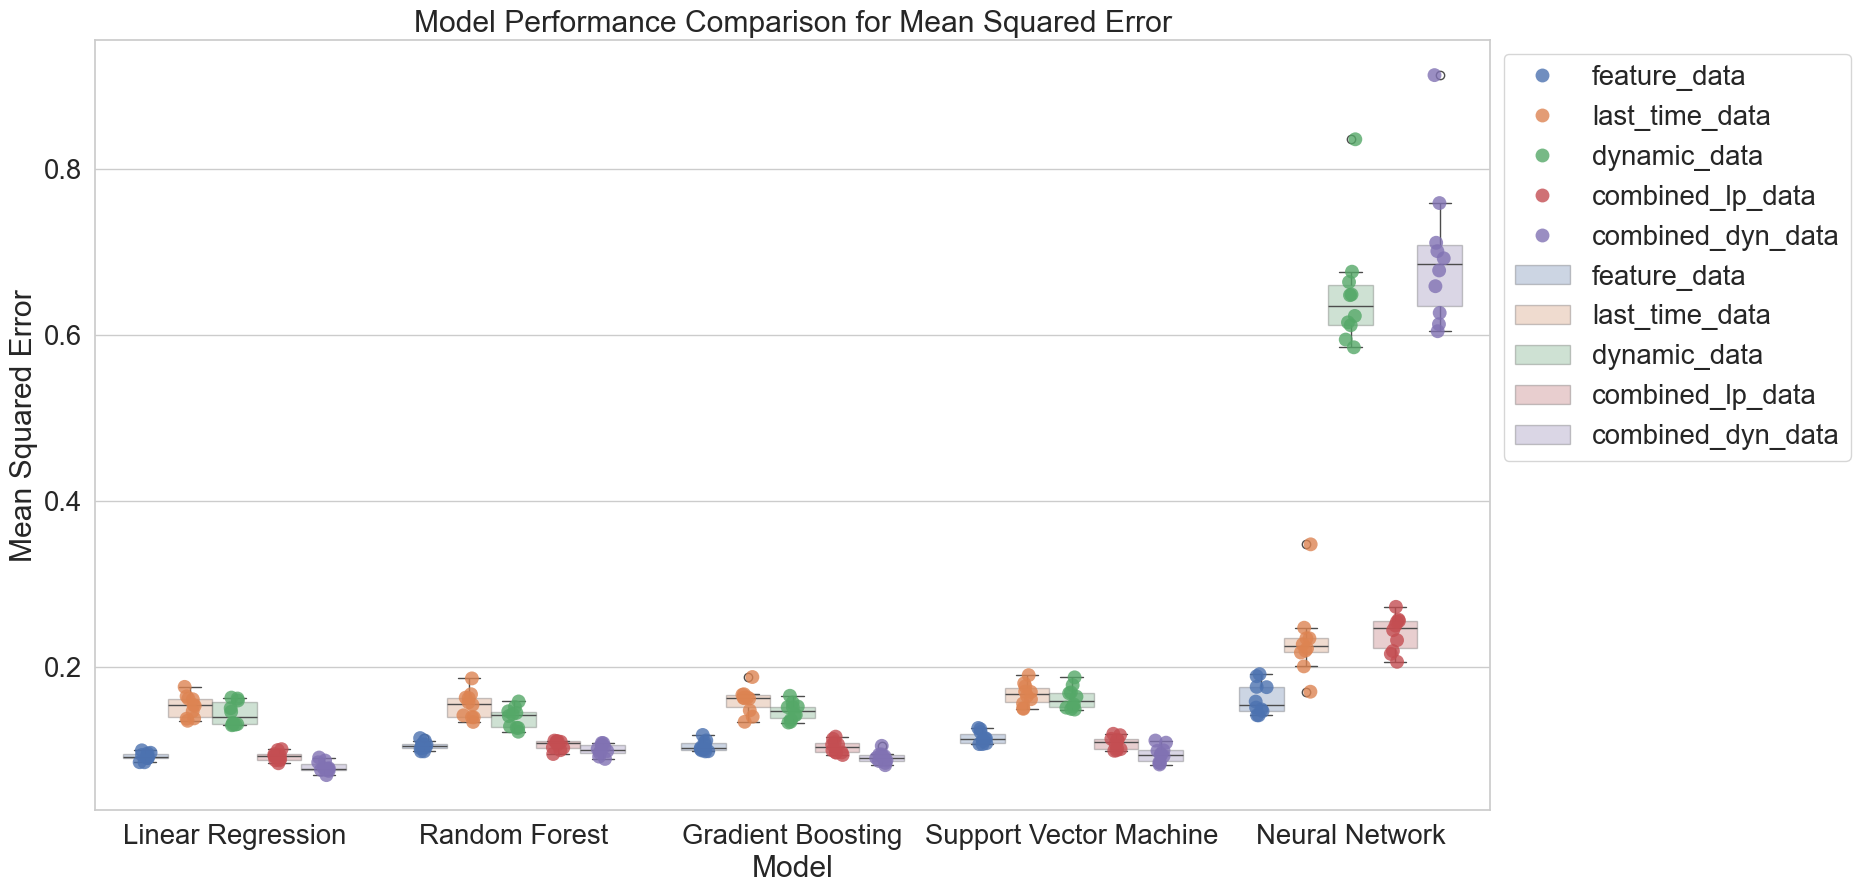

In [46]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Mean Squared Error')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

if save_figures:
    plt.savefig(experiment_folder + 'Fig_14A_all_model_performance_comparison_mse.png')
plt.show()